<a href="https://colab.research.google.com/github/VidyaB333/Supermarket_Sale_Unit_Prediction/blob/main/SuperMarket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

#!pip install pmdarima #autoarima
# This line of code requires restarting of kernel. So mentioned earlier of code part


In [4]:
#uploading data file from local
upload = files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle 

!ls

!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

#Use of Kaggle API to download the dataset
!kaggle competitions download -c m5-forecasting-accuracy
!ls


!unzip sell_prices.csv.zip
!unzip sales_train_validation.csv.zip
!unzip sales_train_evaluation.csv.zip
!unzip sample_submission.csv.zip

!ls

#!unzip sales_train_validation.csv.zip
#!ls

Saving kaggle.json to kaggle.json
kaggle.json  sample_data
 64% 10.0M/15.5M [00:00<00:00, 28.1MB/s]
100% 15.5M/15.5M [00:00<00:00, 39.3MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 162MB/s]
 84% 12.0M/14.2M [00:00<00:00, 42.9MB/s]
100% 14.2M/14.2M [00:00<00:00, 56.3MB/s]
 57% 9.00M/15.8M [00:00<00:00, 41.9MB/s]
100% 15.8M/15.8M [00:00<00:00, 52.8MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 84.0MB/s]
calendar.csv			sample_data
kaggle.json			sample_submission.csv.zip
sales_train_evaluation.csv.zip	sell_prices.csv.zip
sales_train_validation.csv.zip
Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         
Archive:  sales_train_validation.csv.zip
  inflating: sales_train_validation.csv  
Archive:  sales_train_evaluation.csv.zip
  inflating: sales_train_evaluation.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
calendar.csv			sample_data
kaggle.json			sample_submission.csv
sales_train_evaluation.csv	sample_su

In [5]:
#Importing reqquired libraries

import pandas as pd
import numpy as np
import math
import statistics
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [6]:
#Reading csv files into pandas dataframe

submission = pd.read_csv('sample_submission.csv')
sales = pd.read_csv('sales_train_evaluation.csv')
price = pd.read_csv('sell_prices.csv')
#sales_validation = pd.read_csv('sales_train_validation.csv')
calender = pd.read_csv('calendar.csv', parse_dates=['date'], index_col='date')

#parse_dates converts the string content of date column to datetime format
#date column is provided as index of calender dataframe

# EDA ON DATASETS

In [7]:
#EDA on Calender data
calender.head(2)

wm_yr_wk   weekday  wday  ...  snap_CA  snap_TX snap_WI
date                                  ...                          
2011-01-29     11101  Saturday     1  ...        0        0       0
2011-01-30     11101    Sunday     2  ...        0        0       0

[2 rows x 13 columns]

In [8]:
print('Total no of entries: ', calender.shape[0])
print('Entries are available from {} to {}'.format(calender.index[0].date(), calender.index[-1].date()))

Total no of entries:  1969
Entries are available from 2011-01-29 to 2016-06-19


In [9]:
#Check for null value
calender.isnull().sum()

wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [10]:
#Imputing  null values with provided values
#We could use below columns as exogeneous variables while modelling the time series

calender.event_name_1 = calender.event_name_1.fillna('No Event')
calender.event_name_2 = calender.event_name_2.fillna('No Event')
calender.event_type_1 = calender.event_type_1.fillna('--') 
calender.event_type_2 = calender.event_type_2.fillna('--') 


#Below columns are not much important.. so dropping those columns
calender.drop(['snap_CA',	'snap_TX',	'snap_WI'], axis=1, inplace= True)

In [11]:
calender.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1969 entries, 2011-01-29 to 2016-06-19
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wm_yr_wk      1969 non-null   int64 
 1   weekday       1969 non-null   object
 2   wday          1969 non-null   int64 
 3   month         1969 non-null   int64 
 4   year          1969 non-null   int64 
 5   d             1969 non-null   object
 6   event_name_1  1969 non-null   object
 7   event_type_1  1969 non-null   object
 8   event_name_2  1969 non-null   object
 9   event_type_2  1969 non-null   object
dtypes: int64(4), object(6)
memory usage: 169.2+ KB


In [12]:
#Downcasting the columns of dataframe to deal with heavy files

#Converting numerical variables into its appropriate datatypes
calender=calender.astype({'wday':'uint8','month':'uint8', 'month':'uint8','year':'int16', 'wm_yr_wk':'uint16'})

#Converting categorical variables into its appropriate datatypes
calender=calender.astype({'weekday':'category', 'event_type_1':'category', 'event_type_2':'category'})


In [13]:
#Datatype of all coulmns of dataframe
calender.dtypes

wm_yr_wk          uint16
weekday         category
wday               uint8
month              uint8
year               int16
d                 object
event_name_1      object
event_type_1    category
event_name_2      object
event_type_2    category
dtype: object

In [14]:
calender.info() 
#Successfully reduced the size of calender dataframe from 215.4+ KB to 79.5+ KB by downcasting the variables

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1969 entries, 2011-01-29 to 2016-06-19
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   wm_yr_wk      1969 non-null   uint16  
 1   weekday       1969 non-null   category
 2   wday          1969 non-null   uint8   
 3   month         1969 non-null   uint8   
 4   year          1969 non-null   int16   
 5   d             1969 non-null   object  
 6   event_name_1  1969 non-null   object  
 7   event_type_1  1969 non-null   category
 8   event_name_2  1969 non-null   object  
 9   event_type_2  1969 non-null   category
dtypes: category(3), int16(1), object(3), uint16(1), uint8(2)
memory usage: 79.5+ KB


In [15]:
calender.head(3)

wm_yr_wk   weekday  wday  ...  event_type_1  event_name_2 event_type_2
date                                  ...                                         
2011-01-29     11101  Saturday     1  ...            --      No Event           --
2011-01-30     11101    Sunday     2  ...            --      No Event           --
2011-01-31     11101    Monday     3  ...            --      No Event           --

[3 rows x 10 columns]

In [16]:
#EDA on sales_price dataset
print(price.shape)
price.head(5)

(6841121, 4)


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [17]:
print('Total stores: {} store id : {} '.format(price.store_id.nunique(),price.store_id.unique()))
print('Total items: {} '.format(price.item_id.nunique()))

Total stores: 10 store id : ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3'] 
Total items: 3049 


In [18]:
price.info()

price = price.astype({'store_id':'category', 'wm_yr_wk':'uint16', 'sell_price': 'float16' })

print('\n\n')
price.info()
#Memory utilization of this dataframe is reduced from  208.8+ MB to 84.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     object  
 2   wm_yr_wk    uint16  
 3   sell_price  float16 
dtypes: category(1), float16(1), object(1), uint16(1)
memory usage: 84.8+ MB


In [19]:
sales.shape
sales.head()
#1941

id        item_id  ... d_1940 d_1941
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      0      1
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      0      1
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      2      6
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      1      0

[5 rows x 1947 columns]

In [20]:
for item in ['state_id','store_id','cat_id','dept_id']:
  print(sales[item].value_counts())
  print("")

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64

CA_1    3049
CA_2    3049
TX_3    3049
WI_1    3049
WI_3    3049
TX_1    3049
CA_3    3049
CA_4    3049
TX_2    3049
WI_2    3049
Name: store_id, dtype: int64

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64

FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64



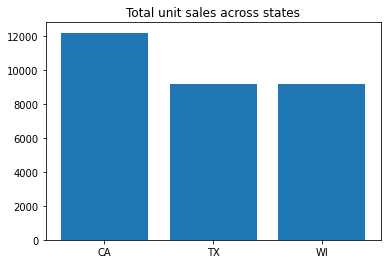

In [21]:
plt.bar(sales.state_id.unique(), sales.state_id.value_counts())
plt.title('Total unit sales across states')
plt.show()

#stores in CA state sold more units compared to other two states

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64


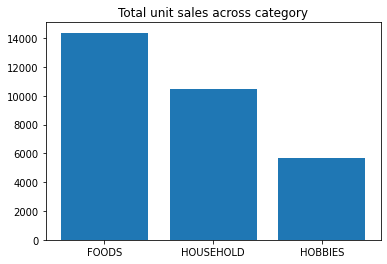

In [22]:
print(sales.cat_id.value_counts())

plt.bar(['FOODS', 'HOUSEHOLD' , 'HOBBIES'], sales.cat_id.value_counts())
plt.title('Total unit sales across category')
plt.show()

#Sales for food category is more than household and hobbies

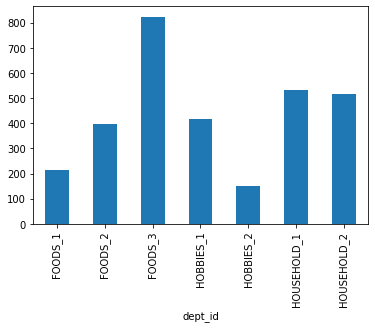

In [23]:
sales.groupby('dept_id')['item_id'].nunique().plot(kind='bar')
plt.show()
#Food_3 department has variety of items compared to other department

In [26]:
sales.info()
print(sales.shape)
print()

#Downcasting the columns of sales dataset
cols = list(sales.columns[6:])
for i in cols:
  sales[i]=sales[i].astype('int8')
print()
sales.info()
#Memory usage has reduced from 448.6+ MB to  57.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int8(1941), object(6)
memory usage: 57.8+ MB
(30490, 1947)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int8(1941), object(6)
memory usage: 57.8+ MB


Splitting the calender dataset

Training dataset -->   d_1 to d_1913 (2011-01-29 to 2016-04-24)

Validation dataset --> d_1914 to d_1941 (2016-04-25 to 2016-05-22)

Testing dataset -->    d_1942 to d_1969 (2016-05-23 to 2016-06-19)



In [27]:

calender_train = calender.iloc[:1913]
calender_validation = calender.iloc[1913:1941]
calender_test = calender.iloc[1941:]

print('Length of training dataset: {0}\nLength of Validation dataset: {1}\nLength of testing dataset: {2}\n'.format(len(calender_train), len(calender_validation), len(calender_test)))


Length of training dataset: 1913
Length of Validation dataset: 28
Length of testing dataset: 28



Splitting the sales dataset into train and validation set

In [29]:
sales_train= sales.iloc[:,:1919]
#Using this dataset for training the model
sales_train.head()

id        item_id  ... d_1912 d_1913
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      1      1
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      1      1
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      7      2
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      2      4

[5 rows x 1919 columns]

dept_id     FOODS_1  FOODS_2  FOODS_3  ...  HOBBIES_2  HOUSEHOLD_1  HOUSEHOLD_2
date                                   ...                                     
2011-01-29   2343.0   4094.0  14949.0  ...      154.0       4105.0       1584.0
2011-01-30   2216.0   4209.0  13773.0  ...      185.0       3858.0       1776.0
2011-01-31   1657.0   3174.0  11831.0  ...      185.0       2827.0       1100.0

[3 rows x 7 columns]


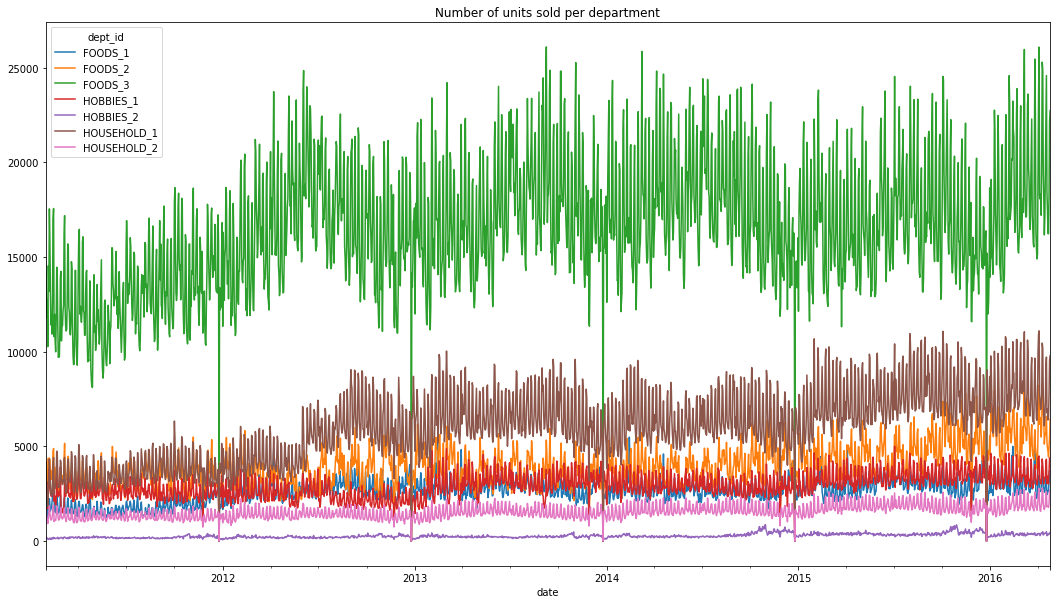

In [30]:
department=sales_train.groupby('dept_id').sum()
department = department.T
department.index= calender.index[:calender_train.shape[0]]
print(department.head(3))


department.plot(figsize=(18, 10))
plt.title('Number of units sold per department')
plt.show()

#Total items sold from FOOD_3 department is higher than other departments
# as total options in FOOD_3 department is more than other department
#HOBBIES_2 department has less number of options so does less number total items sold

In [31]:
sales_train

id        item_id  ... d_1912 d_1913
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      1      1
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      1      1
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      7      2
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      2      4
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823  ...      0      1
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825  ...      1      0
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826  ...      1      3
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827  ...      0      0

[30490 rows x 1919 columns]

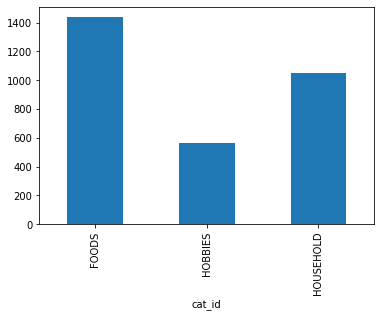

In [32]:
sales.groupby(['cat_id'])['item_id'].nunique().plot(kind='bar')
plt.show()

#Food category has more number of options of items

cat_id        FOODS  HOBBIES  HOUSEHOLD
date                                   
2011-01-29  21386.0   3764.0     5689.0
2011-01-30  20198.0   3357.0     5634.0
2011-01-31  16662.0   2682.0     3927.0
2011-02-01  17854.0   2669.0     3865.0
2011-02-02  14347.0   1814.0     2729.0


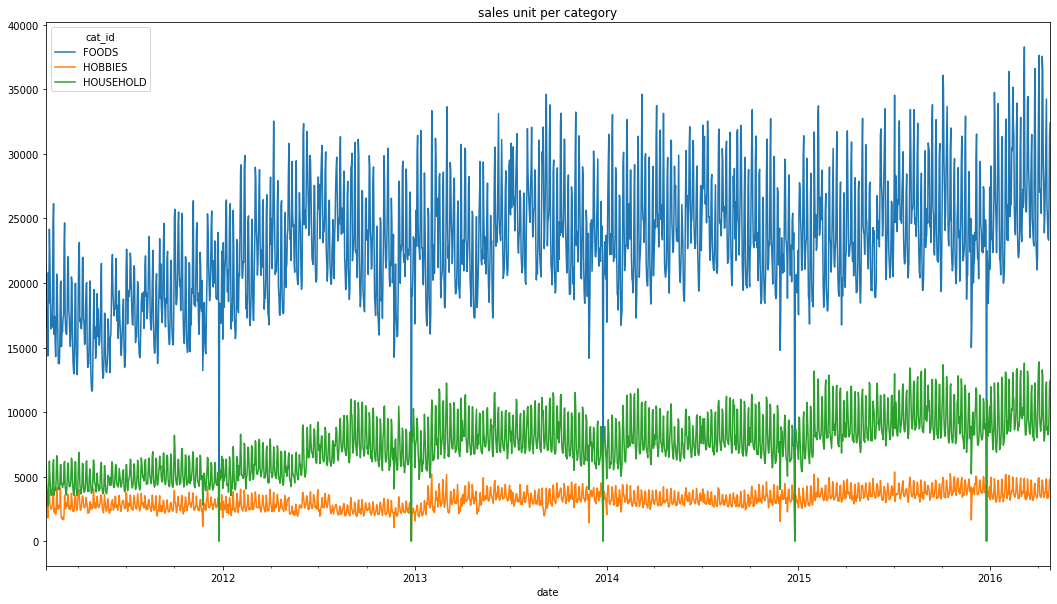

In [33]:
category=sales_train.groupby('cat_id').sum()
category = category.T
category.index= calender.index[:calender_train.shape[0]]
print(category.head(5))


category.plot(figsize=(18, 10))
plt.title('sales unit per category')
plt.show()

#Items sold in food category is higher compared to other category

In [34]:
sales_train.groupby('state_id')['item_id'].nunique()
#Items are same for all 3 states stores

state_id
CA    3049
TX    3049
WI    3049
Name: item_id, dtype: int64

state_id         CA      TX      WI
date                               
2011-01-29  13683.0  8670.0  8486.0
2011-01-30  12525.0  8862.0  7802.0
2011-01-31   9852.0  6522.0  6897.0
2011-02-01  10535.0  7381.0  6472.0
2011-02-02   9669.0  5912.0  3309.0


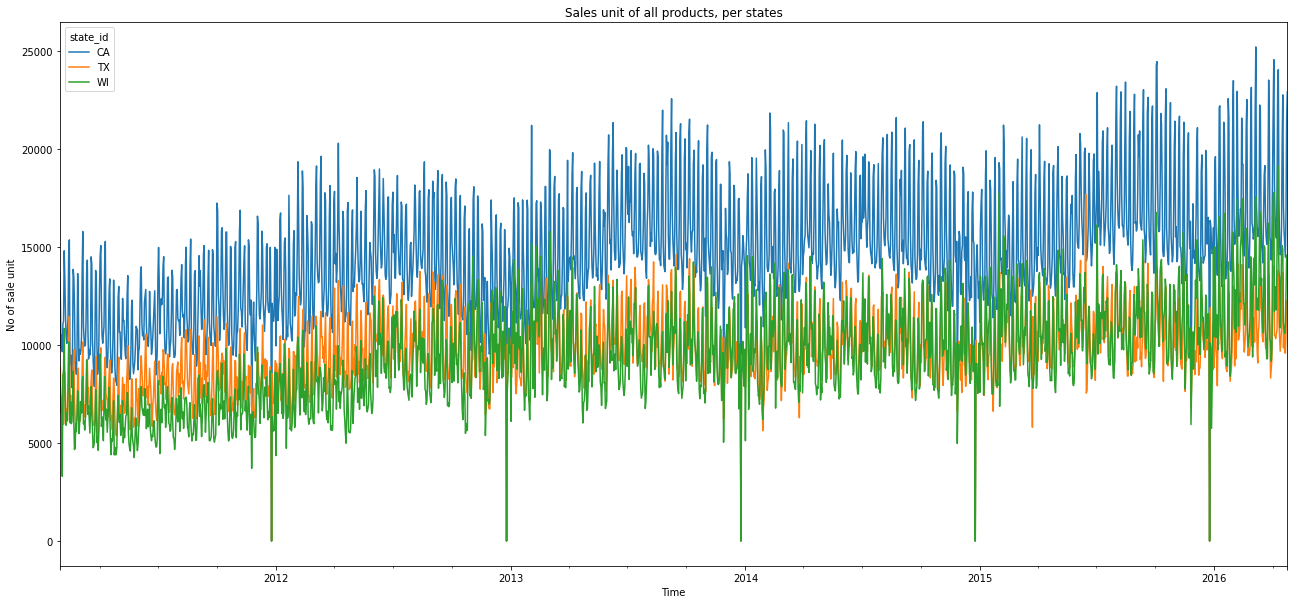

In [35]:
state_train=sales_train.groupby('state_id').sum()
state_train = state_train.T
state_train.index= calender.index[:calender_train.shape[0]]
print(state_train.head())


state_train.plot(figsize=(22,10))
plt.ylabel('No of sale unit')
plt.xlabel('Time')
plt.title('Sales unit of all products, per states')
plt.show()

store_id      CA_1    CA_2    CA_3    CA_4  ...    TX_3    WI_1    WI_2    WI_3
date                                        ...                                
2011-01-29  4081.0  3494.0  4483.0  1625.0  ...  2518.0  2704.0  2256.0  3526.0
2011-01-30  3643.0  3046.0  4059.0  1777.0  ...  2750.0  2194.0  1922.0  3686.0
2011-01-31  2816.0  2121.0  3529.0  1386.0  ...  1969.0  1562.0  2018.0  3317.0
2011-02-01  2795.0  2324.0  3976.0  1440.0  ...  2169.0   995.0  2266.0  3211.0
2011-02-02  2630.0  1942.0  3561.0  1536.0  ...  1726.0     2.0  1175.0  2132.0

[5 rows x 10 columns]


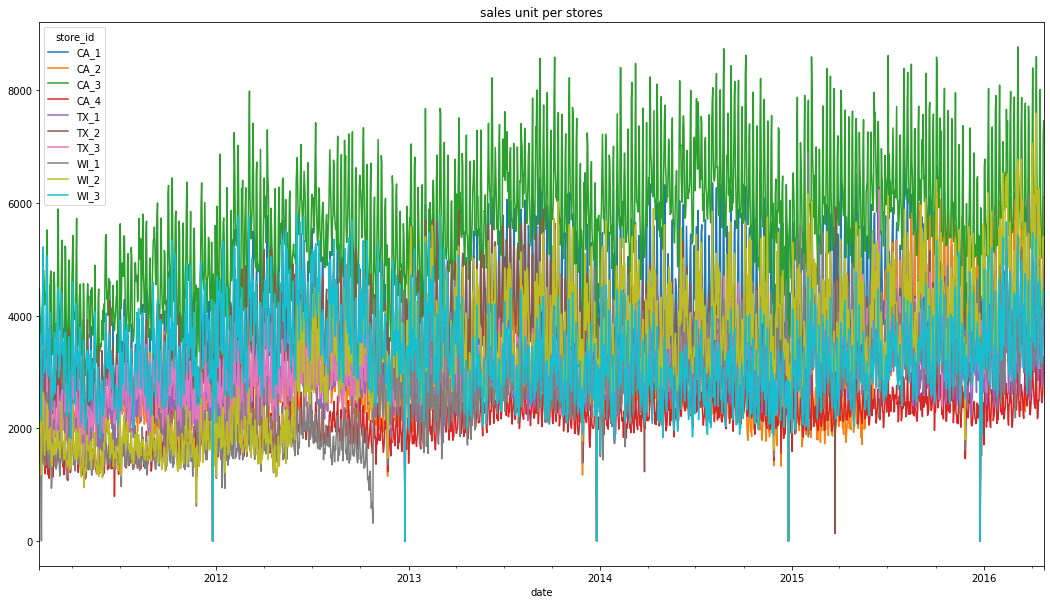

In [36]:
store=sales_train.groupby('store_id').sum()
store = store.T
store.index= calender.index[:state_train.shape[0]]
print(store.head(5))


store.plot(figsize=(18, 10))
plt.title('sales unit per stores')
plt.show()

In [37]:
state_train

state_id         CA       TX       WI
date                                 
2011-01-29  13683.0   8670.0   8486.0
2011-01-30  12525.0   8862.0   7802.0
2011-01-31   9852.0   6522.0   6897.0
2011-02-01  10535.0   7381.0   6472.0
2011-02-02   9669.0   5912.0   3309.0
...             ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0
2016-04-21  14488.0   9602.0  10943.0
2016-04-22  16839.0  10615.0  12807.0
2016-04-23  21578.0  12266.0  14606.0
2016-04-24  22931.0  12282.0  14326.0

[1913 rows x 3 columns]

Unit sales of all products, aggregated for all stores/states

In [38]:
sales_allstate = state_train.sum(axis=1)
sales_allstate

date
2011-01-29    30839.0
2011-01-30    29189.0
2011-01-31    23271.0
2011-02-01    24388.0
2011-02-02    18890.0
               ...   
2016-04-20    35343.0
2016-04-21    35033.0
2016-04-22    40261.0
2016-04-23    48450.0
2016-04-24    49539.0
Length: 1913, dtype: float64

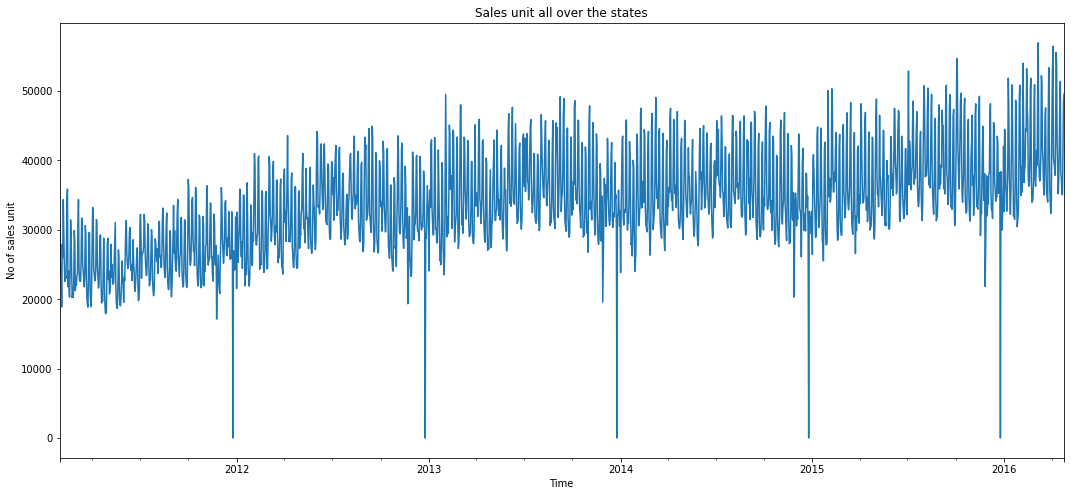

In [39]:
sales_allstate.plot(figsize=(18,8))
plt.title('Sales unit all over the states')
plt.xlabel('Time')
plt.ylabel('No of sales unit')
plt.show()

In [40]:
#On 25th December, value is very small.
for i in ['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25']:
  print(sales_allstate.loc[i])

13.0
11.0
20.0
20.0
14.0


In [41]:
# Handling the currupt data

#On 26th December, value of sales unit is very less.. so imputing the average values of last 7 observed values
years = [2011,2012,2013,2014,2015]
for i in range(len(years)):
  sum = 0
  value1 =  sales_allstate.loc[str(years[i]) +'-12-24']
  value2 =  sales_allstate.loc[str(years[i]) +'-12-23']
  value3 =  sales_allstate.loc[str(years[i]) +'-12-22']
  value4 =  sales_allstate.loc[str(years[i]) +'-12-21']
  value5 =  sales_allstate.loc[str(years[i]) +'-12-20']
  value6 =  sales_allstate.loc[str(years[i]) +'-12-19']
  value7 =  sales_allstate.loc[str(years[i]) +'-12-18']


  sum = int((value1+value2+value3+value4+value5+value6+ value7)/7)
  sales_allstate.loc[str(years[i]) +'-12-25'] = sum

In [42]:
sales_allstate.loc['2015-12-25']

38118.0

In [43]:
#After orking on currupt data
for i in ['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25']:
  print(sales_allstate.loc[i])

27986.0
32741.0
33595.0
33684.0
38118.0


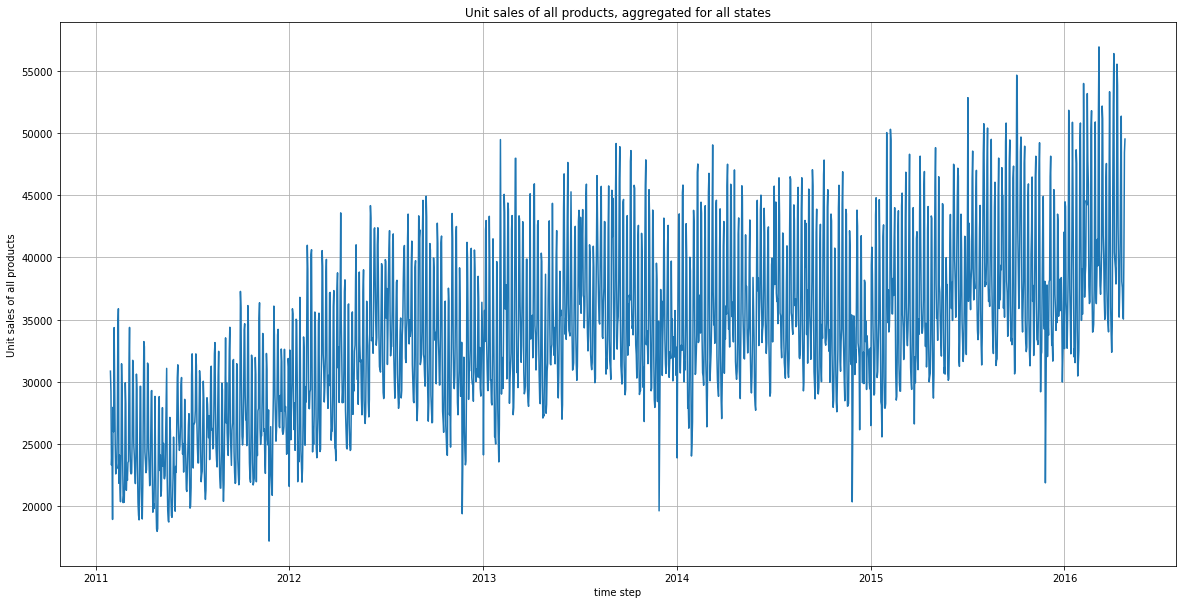

In [44]:
plt.figure(figsize=(20,10))
plt.plot(sales_allstate)
plt.grid()
plt.title('Unit sales of all products, aggregated for all states')
plt.xlabel('time step')
plt.ylabel('Unit sales of all products')
plt.show()

sales_allstate is our time series to work on.
It contains number of unit sales across all the states.

For applying statistical models on time series, it should be stationary in naure.


Stationarity of time seies is checked using ADF, KPSS statistical tests, using graphical representation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


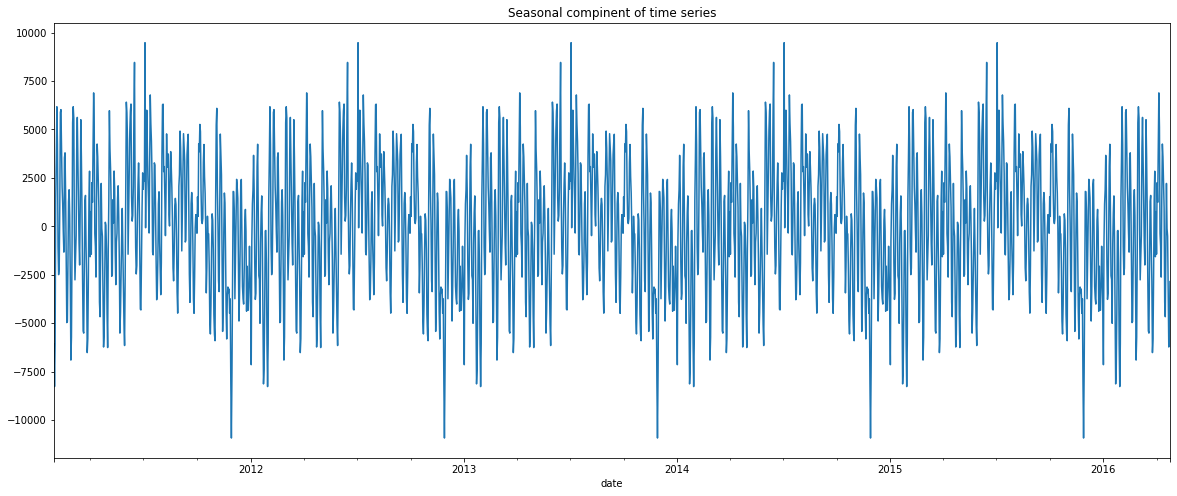

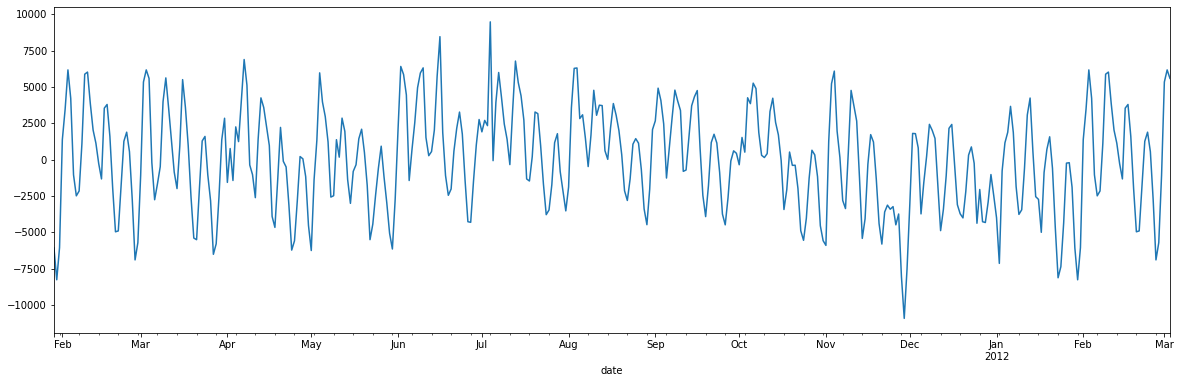

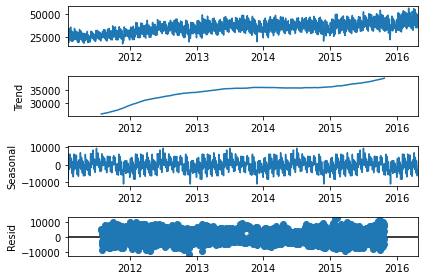

In [45]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sales_allstate,  model='additive', freq = 365)
result.seasonal.plot(figsize=(20,8))#figsize=(20,10)
plt.title('Seasonal compinent of time series')
plt.show()

result.seasonal[0:400].plot(figsize=(20,6))
plt.show()

result.plot()
plt.show()

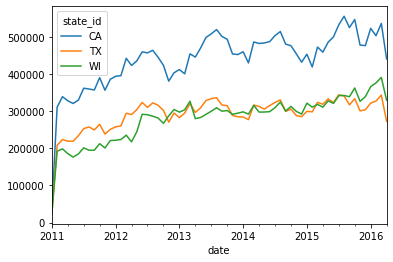

In [46]:
re =state_train.resample('m').sum()
re.plot()
plt.show()
#below plot shows that total items sold across different state shows same inceasing trend 

In [47]:
state_train

state_id         CA       TX       WI
date                                 
2011-01-29  13683.0   8670.0   8486.0
2011-01-30  12525.0   8862.0   7802.0
2011-01-31   9852.0   6522.0   6897.0
2011-02-01  10535.0   7381.0   6472.0
2011-02-02   9669.0   5912.0   3309.0
...             ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0
2016-04-21  14488.0   9602.0  10943.0
2016-04-22  16839.0  10615.0  12807.0
2016-04-23  21578.0  12266.0  14606.0
2016-04-24  22931.0  12282.0  14326.0

[1913 rows x 3 columns]

In [48]:
#From the figure we can say that, there is seasonality present in time seies.
#Repitiong patterns are available.

In [49]:
#VALIDATION DATASET

sales1 = sales.iloc[:,:6 ]
#Using this dataset for training the model
sales2 = sales.iloc[:, 1919:]

sales_val = pd.concat([sales1, sales2], axis=1)
sales_val= sales_val.groupby('state_id').sum().T
sales_val.index= calender.index[1914:1942]

In [50]:
sales_val

state_id         CA       TX       WI
date                                 
2016-04-26  17268.0  10662.0  10607.0
2016-04-27  15012.0   9933.0  10542.0
2016-04-28  14836.0   9575.0  10034.0
2016-04-29  14664.0   9655.0  10413.0
2016-04-30  16924.0  12162.0  13554.0
2016-05-01  22071.0  12694.0  15408.0
2016-05-02  23689.0  14193.0  15150.0
2016-05-03  19117.0  10719.0  13345.0
2016-05-04  17830.0  11949.0  14279.0
2016-05-05  17266.0   9909.0  12426.0
2016-05-06  16197.0  10833.0  13733.0
2016-05-07  17382.0  11773.0  14138.0
2016-05-08  22863.0  13412.0  16940.0
2016-05-09  19704.0  11385.0  14264.0
2016-05-10  18916.0  12035.0  15449.0
2016-05-11  16971.0  10580.0  11828.0
2016-05-12  16191.0  11314.0  14743.0
2016-05-13  15498.0  11491.0  13514.0
2016-05-14  18215.0  12320.0  13282.0
2016-05-15  22781.0  12366.0  18649.0
2016-05-16  24448.0  16249.0  18968.0
2016-05-17  17721.0  12228.0  12413.0
2016-05-18  16150.0  11370.0  11257.0
2016-05-19  15678.0  10375.0  11043.0
2016-05-20  16297.0   9162.0  11504.0
2016-05-21  17430.0  12303.0  12819.0
2016-05-22  22847.0  13681.0  14734.0
2016-05-23  24644.0  14815.0  14879.0

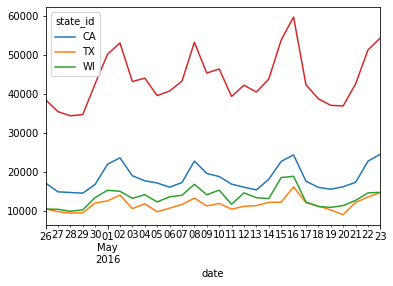

In [51]:
sales_allstate_val = sales_val.sum(axis=1)
sales_val.plot()
sales_allstate_val.plot()
plt.show()

In [52]:
#Creating dataframe for storing the validation results
validation = pd.DataFrame(sales_allstate_val.values, columns=['Actual'], index=sales_val.index)
validation.head()

Actual
date               
2016-04-26  38537.0
2016-04-27  35487.0
2016-04-28  34445.0
2016-04-29  34732.0
2016-04-30  42640.0

Prediction using below method

Naive Method:
1: Average of training set 
2: Naive method

Statistical Method:
3:ARIMA
4:Prophet

# Average Naive method

RMSE using averge naive method:  11818.692522370908


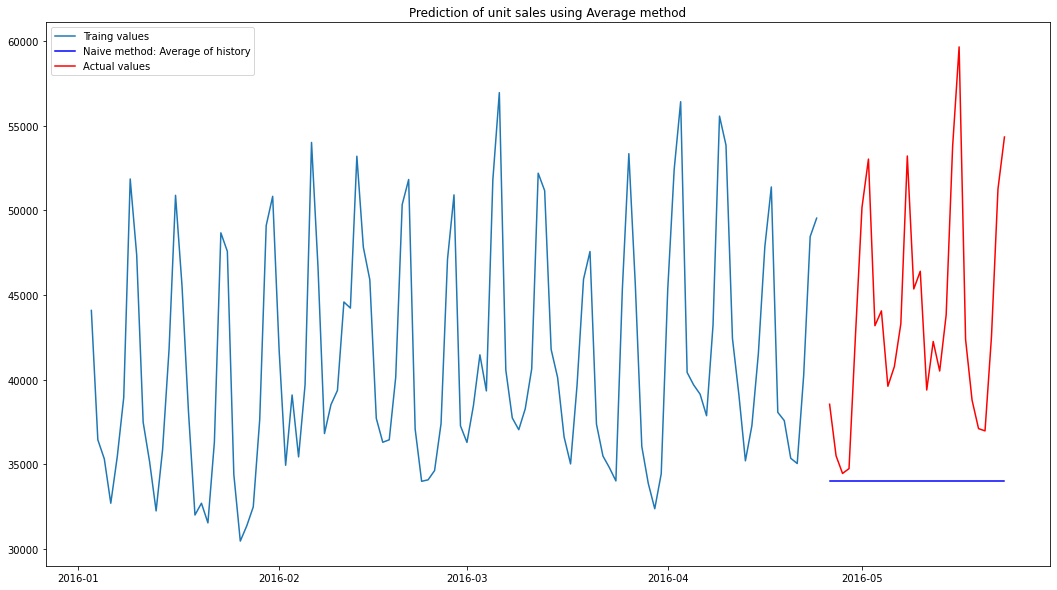

In [53]:
#Prediction using average method
validation['Average'] = sales_allstate.mean()

print('RMSE using averge naive method: ', (math.sqrt(mean_squared_error(validation.Actual,validation.Average))))

plt.figure(figsize = (18,10))
plt.plot(sales_allstate[1800:], label='Traing values')
plt.plot(validation.Average, color = 'b', label = 'Naive method: Average of history')
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.title('Prediction of unit sales using Average method')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


RMSE using WFV on average naive method:  6600.942083002346



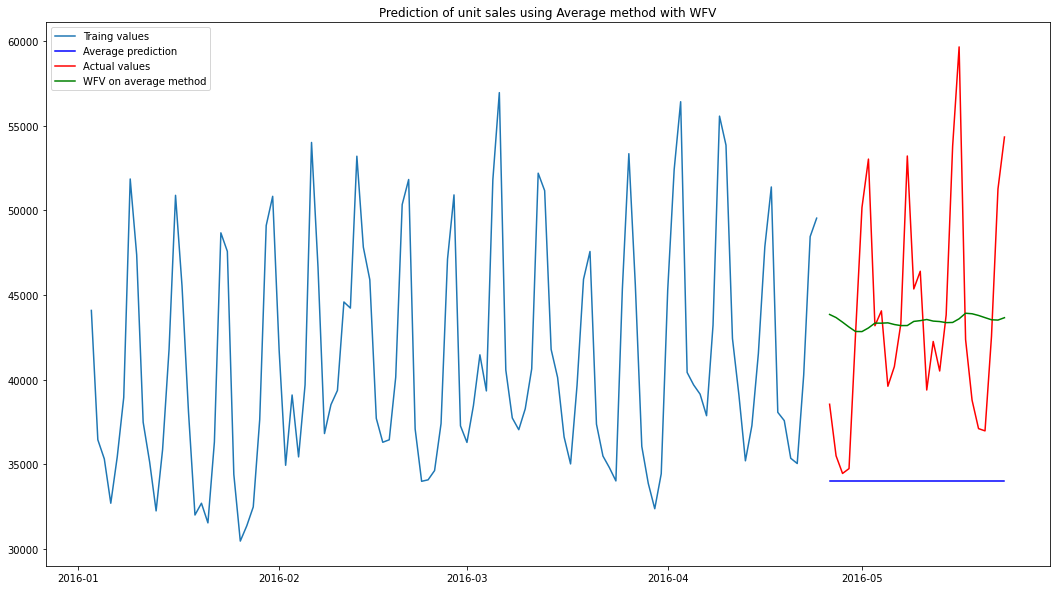

In [54]:
#Prediction using WFV on average method
validation['WFV_avg'] = [0]* len(validation.Actual)
x_train = validation.Actual.values
for i in range(len(validation.Actual)):
  validation['WFV_avg'].iloc[i] = x_train.mean()

  x_train = np.append(x_train, validation.Actual[i])


print('RMSE using WFV on average naive method: ', math.sqrt(mean_squared_error(validation.Actual,validation.WFV_avg)))

print()
plt.figure(figsize = (18,10))
plt.plot(sales_allstate[1800:], label='Traing values')
plt.plot(validation.Average, color = 'b', label = 'Average prediction')
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.WFV_avg, color='g', label = 'WFV on average method')
plt.title('Prediction of unit sales using Average method with WFV')
plt.legend()
plt.show()

# Naive persistence model

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




RMSE using naive method 6499.95284873008


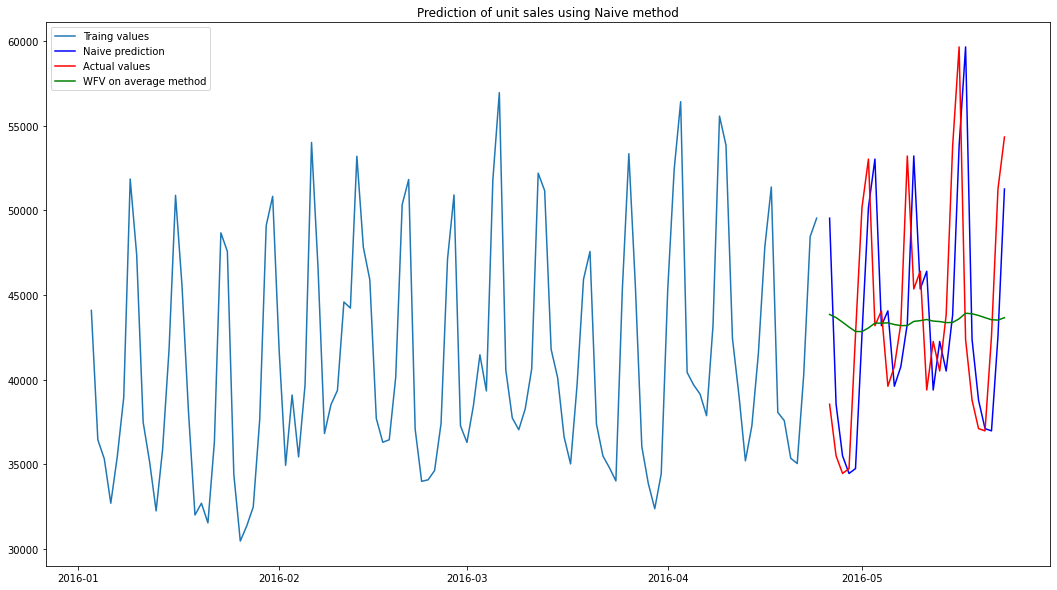

In [113]:
#Prediction using Naive method
validation['Naive'] = [0]*len(validation)
validation.Naive.iloc[0]= sales_allstate[-1]
for i in range(1, len(validation)):
  validation.Naive.iloc[i]= validation.Actual[i-1]


print('\nRMSE using naive method', (math.sqrt(mean_squared_error(validation.Actual,validation.Naive))))

plt.figure(figsize = (18,10))
plt.plot(sales_allstate[1800:], label='Traing values')
plt.plot(validation.Naive, color = 'b', label = 'Naive prediction')
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.WFV_avg, color='g', label = 'WFV on average method')
plt.title('Prediction of unit sales using Naive method')
plt.legend()
plt.show()

# ARIMA Model

Predictions using ARIMA models

Predictions on stationary time series are more accurate than non stationary time series

Stationarity test: ADF, KPSS





adf TEST

Null hypothesis: TS is non stationary
Alternate hypothesis: TS is stationary

In [56]:
#Stationarity check of time series
from statsmodels.tsa.stattools import adfuller, kpss

result = adfuller(sales_allstate)

print('ADF Test Statics: %f'%result[0])
print('p value: %f'%result[1])
print('Critical values:')
for key, value  in  result[4].items():
  print('{} : {}'.format(key , value))

print('\n')
if result[0]< result[4]['5%']:
  print('ADF Test: Time series is stationary')
else:
  print('ADF Test : Time series is not stationary')

print('\n')

result = kpss(sales_allstate)

print('KPSS Test Statics: %f'%result[0])
print('p value: %f'%result[1])
print('Critical values:')
for key, value  in  result[3].items():
  print('{} : {}'.format(key , value))
print()
if result[0]> result[3]['5%']:
  print('KPSS Test : Time series is non stationary')
else:
  print('ADF Test: Time series is  stationary')

print()

ADF Test Statics: -1.477859
p value: 0.544434
Critical values:
1% : -3.433822016251123
5% : -2.8630736989499335
10% : -2.567586484303047


ADF Test : Time series is not stationary


KPSS Test Statics: 5.476901
p value: 0.010000
Critical values:
10% : 0.347
5% : 0.463
2.5% : 0.574
1% : 0.739

KPSS Test : Time series is non stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [57]:
#From both adf and kpss, it shows that ts is non stationary... Need to make it stationary

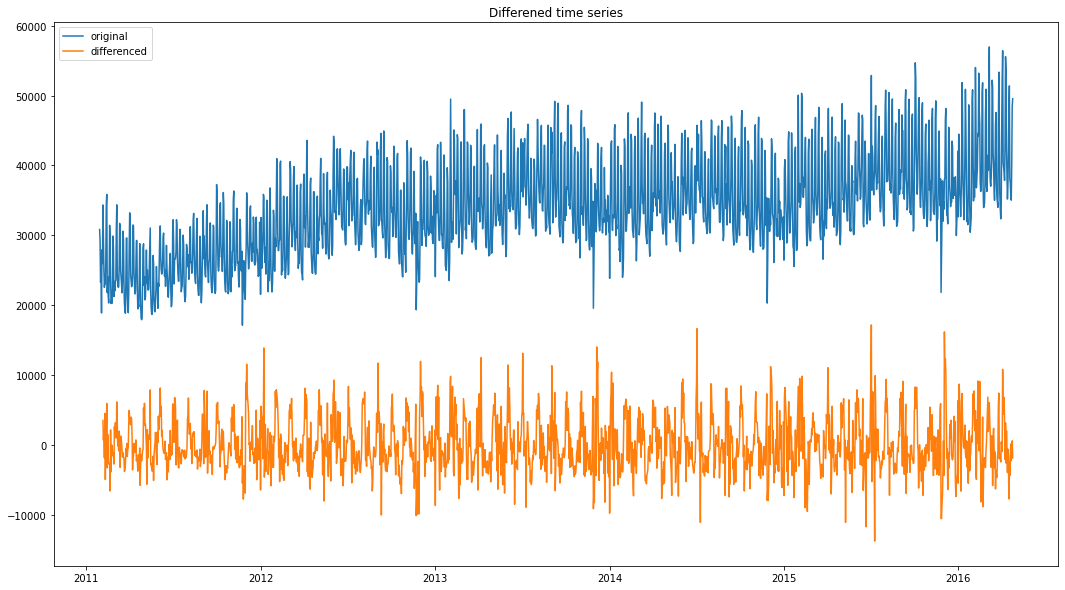

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.


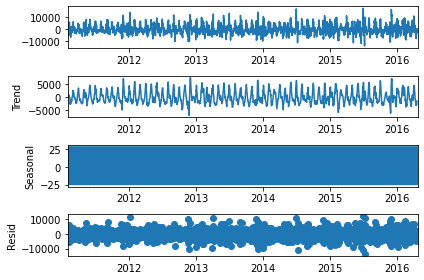

In [58]:
differening = sales_allstate.diff(7)
plt.figure(figsize =(18,10))
plt.plot(sales_allstate, label = 'original')
plt.plot(differening, label = 'differenced')
plt.title('Differened time series')
plt.legend()
plt.show()

differening = differening[7:]
result = seasonal_decompose(differening,  model='additive', freq=7)
result.plot()
plt.show()

In [59]:
#Need to check whether the differenced time series is stationary or not
#Stationarity of time series

from statsmodels.tsa.stattools import adfuller, kpss

result = adfuller(differening)

print('ADF Test Statics: %f'%result[0])
print('p value: %f'%result[1])
print('Critical values:')
for key, value  in  result[4].items():
  print('{} : {}'.format(key , value))

print('\n')
if result[0]< result[4]['5%']:
  print('ADF Test: Time series is stationary')
else:
  print('ADF Test : Time series is not stationary')

print('\n')

result = kpss(differening)

print('KPSS Test Statics: %f'%result[0])
print('p value: %f'%result[1])
print('Critical values:')
for key, value  in  result[3].items():
  print('{} : {}'.format(key , value))
print()
if result[0]> result[3]['5%']:
  print('KPSS Test : Time series is non stationary')
else:
  print('ADF Test: Time series is  stationary')

print()

ADF Test Statics: -20.018729
p value: 0.000000
Critical values:
1% : -3.4338294057711836
5% : -2.863076961232155
10% : -2.567588221339588


ADF Test: Time series is stationary


KPSS Test Statics: 0.027257
p value: 0.100000
Critical values:
10% : 0.347
5% : 0.463
2.5% : 0.574
1% : 0.739

ADF Test: Time series is  stationary



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [60]:
#From both ADF and KPSS, it shows that after differeing the ts, it becomes stationary

AUTOCORRELATION AND PARTIAL AUTOCORRELATION OF ORIGINAL TIME SERIES


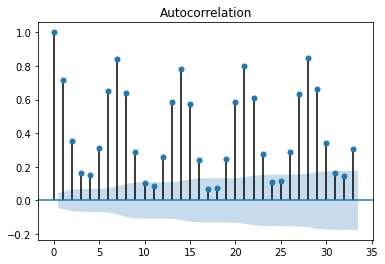

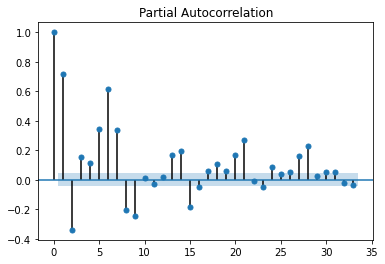

AUTOCORRELATION AND PARTIAL AUTOCORRELATION OF DIFFERENCED TIME SERIES


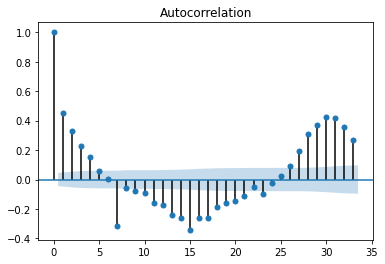

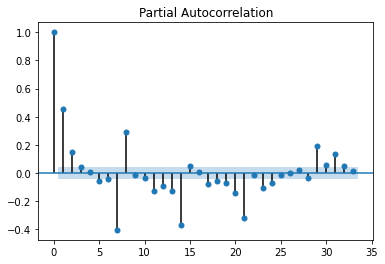

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print('AUTOCORRELATION AND PARTIAL AUTOCORRELATION OF ORIGINAL TIME SERIES')
plot_acf(sales_allstate)
plt.show()

plot_pacf(sales_allstate)
plt.show()

print('AUTOCORRELATION AND PARTIAL AUTOCORRELATION OF DIFFERENCED TIME SERIES')
plot_acf(differening)
plt.show()

plot_pacf(differening)
plt.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(2, 1, 5)x(1, 1, [1], 7)   Log Likelihood              -17838.129
Date:                             Wed, 24 Mar 2021   AIC                          35696.257
Time:                                     16:34:46   BIC                          35751.780
Sample:                                 01-29-2011   HQIC                         35716.694
                                      - 04-24-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1307      0.099     -1.318      0.187      -0.325       0.064
ar.L2          0.7490      

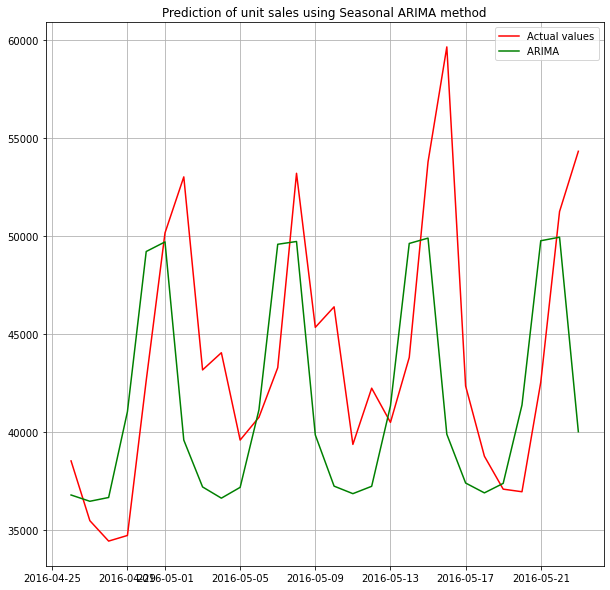

In [62]:
#Prediction using Seasonal ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(sales_allstate, order=(2,1,5), seasonal_order=(1,1,1,7)).fit()

# summary of fit model
print(model.summary())

pred = model.predict(start=sales_allstate.shape[0], end=sales_allstate.shape[0]+len(validation))
validation['ARIMA'] = pred

print('RMSE USING arma MODEL: ',(math.sqrt(mean_squared_error(validation.Actual,validation.ARIMA))))

plt.figure(figsize = (10,10))
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.ARIMA, color = 'g', label = 'ARIMA ')
plt.title('Prediction of unit sales using Seasonal ARIMA method')
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1913, predicted value: [39446.5962835] 


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1914, predicted value: [36336.23316266] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1915, predicted value: [35722.33807047] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1916, predicted value: [35445.07304896] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1917, predicted value: [39719.02193777] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1918, predicted value: [49657.63434475] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1919, predicted value: [50060.08086095] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1920, predicted value: [41195.30863252] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1921, predicted value: [39430.34772738] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1922, predicted value: [40462.166444] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1923, predicted value: [39774.17912762] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1924, predicted value: [44186.53398212] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1925, predicted value: [51862.58235825] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1926, predicted value: [52397.10881798] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1927, predicted value: [38855.26530831] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1928, predicted value: [40911.81802612] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1929, predicted value: [38677.52593503] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1930, predicted value: [39972.66243544] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1931, predicted value: [44875.74730918] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1932, predicted value: [51087.62366875] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1933, predicted value: [52892.88561236] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1934, predicted value: [46027.60498888] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1935, predicted value: [40957.6685074] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1936, predicted value: [38518.42909841] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1937, predicted value: [39326.2305976] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1938, predicted value: [40606.3479484] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1939, predicted value: [51887.97589678] 


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


length of training set : 1940, predicted value: [50963.43136948] 
RMSE USING arma MODEL:  3097.396363183483


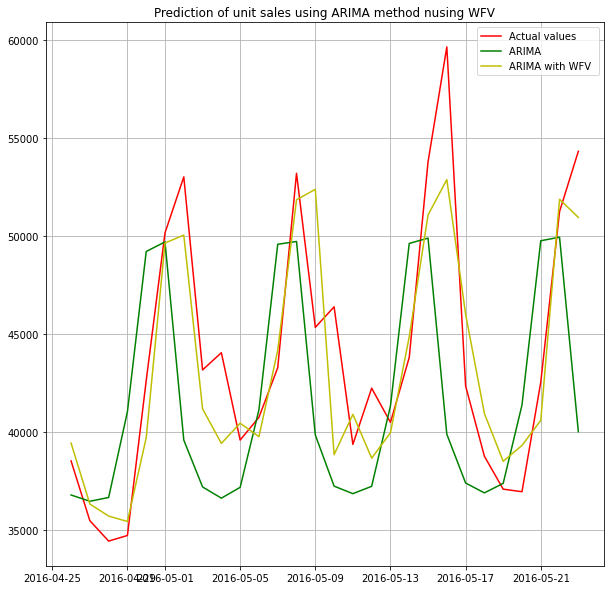

In [63]:
#Prediction using WFV on ARIMA method
validation['WFV_ARIMA'] = [0]* len(validation.Actual)
x_train = sales_allstate.values
for i in range(len(validation.Actual)):
  model = SARIMAX(x_train, order=(2,1,5), seasonal_order=(1,1,1,7)).fit()
  v = model.forecast()
  
  print('length of training set : {}, predicted value: {} '.format(len(x_train), v))
  validation['WFV_ARIMA'].iloc[i] = v

  x_train = np.append(x_train, validation.Actual[i])

print('RMSE USING arma MODEL: ',(math.sqrt(mean_squared_error(validation.Actual,validation.WFV_ARIMA))))

plt.figure(figsize = (10,10))
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.ARIMA, color = 'g', label = 'ARIMA ')

plt.plot(validation.WFV_ARIMA, color = 'y', label = 'ARIMA with WFV ')
plt.title('Prediction of unit sales using ARIMA method nusing WFV')
plt.grid()
plt.legend()
plt.show()

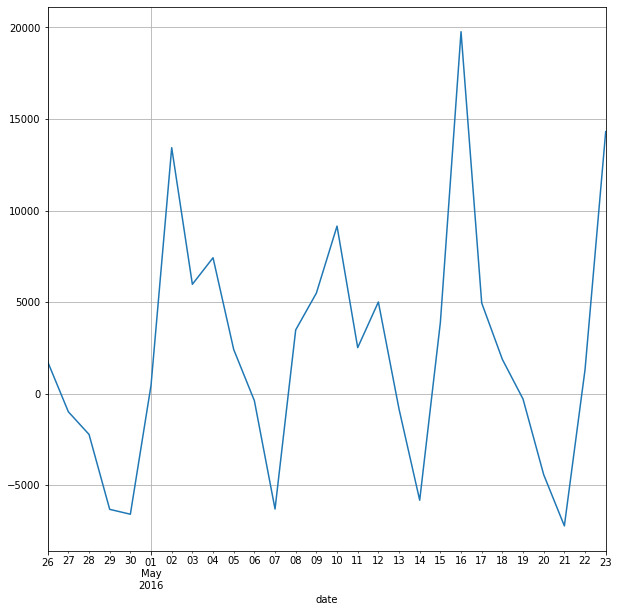

In [64]:
#Evaluation on residuals of model

T = validation.Actual-validation.ARIMA
T.plot(figsize=(10,10))
plt.grid()
plt.show()

#fROM BELOW GRAPH, WE CAN SEE THAT, 
#1:residuals are not normally distrributed
#2:varaiance is not constant

#Model is not capturing the data correctly.

# AUTO ARIMA Model

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=6.90 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=38172.731, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=36714.913, Time=3.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=37548.534, Time=2.52 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=38165.183, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=38137.108, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=inf, Time=6.66 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=37552.590, Time=2.01 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : BIC=36896.368, Time=1.56 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : BIC=36655.471, Time=4.41 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : BIC=37907.676, Time=0.30 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : BIC=36561.534, Time=6.03 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : BIC=37522.455, Time=0.81 sec
 ARIMA(3,1,0)(1,0,1)[7] intercept   : BIC=inf, Time=7.48 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   :

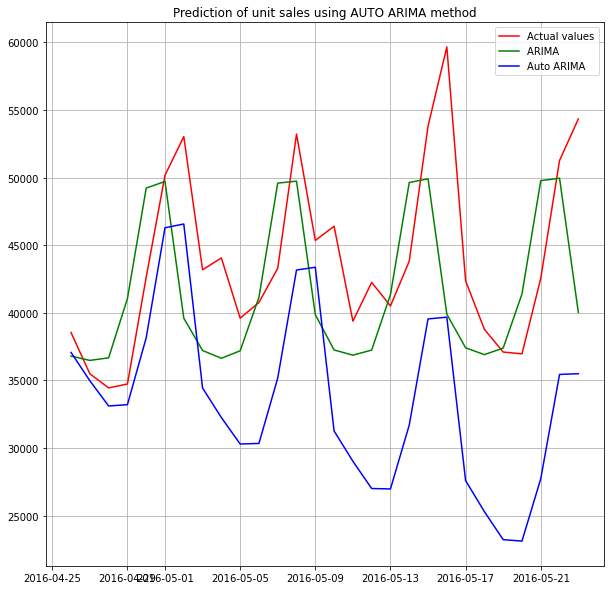

In [65]:

from pmdarima.arima import auto_arima
arima_model = auto_arima(sales_allstate, start_p=1, d=1, start_q=1, max_p=10, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=1, max_D=1, max_Q=1, max_order=5, m=7, seasonal=True, stationary=False, information_criterion='bic', alpha=0.05, trace=True)
arima_model.summary()
# Perform out-of-sample predictions for the entire test data
forecast = arima_model.predict(n_periods=28)
validation['AutoARIMA'] = forecast

print('RMSE using AUTOARIMA: ', (math.sqrt(mean_squared_error(validation.Actual,validation.AutoARIMA))))

plt.figure(figsize = (10,10))
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.ARIMA, color = 'g', label = 'ARIMA ')
plt.plot(validation.AutoARIMA, color = 'b', label = 'Auto ARIMA ')
plt.title('Prediction of unit sales using AUTO ARIMA method')
plt.grid()
plt.legend()
plt.show()

In [66]:
#AUTOARIMA is not working fine here
#Need to check autoarima with WFV

#Expoential smoothing model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


RMSE using Expoential smoothing :  7010.449841184916


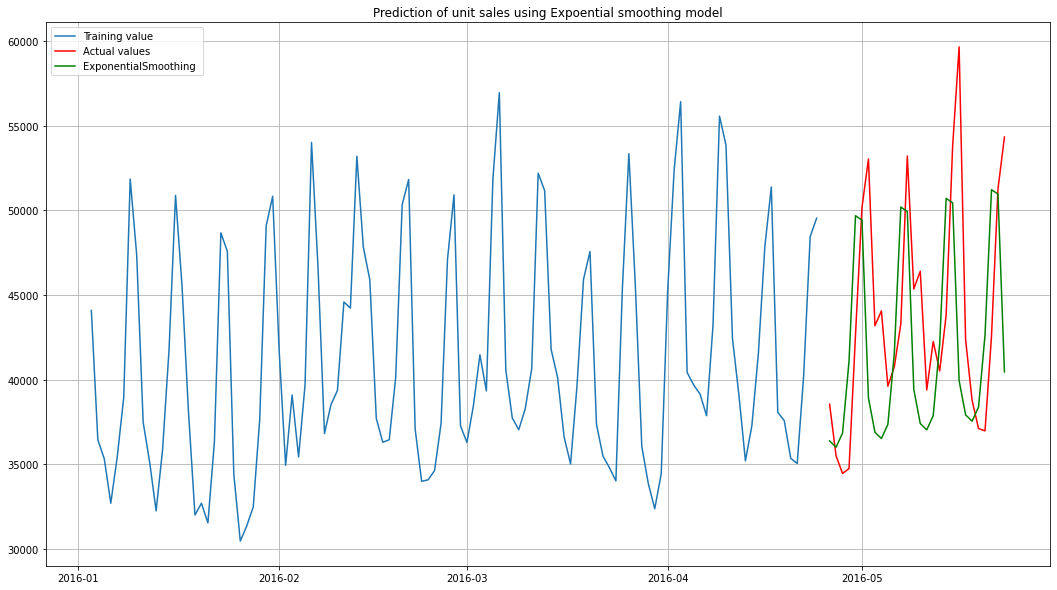

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

esmodel = ExponentialSmoothing(sales_allstate, trend='additive', seasonal='additive').fit()
espredict = esmodel.predict(start=sales_allstate.shape[0], end=sales_allstate.shape[0] + validation.shape[0])

validation['ExponentialSmoothing'] = espredict

print('RMSE using Expoential smoothing : ', math.sqrt(mean_squared_error(validation.Actual, validation.ExponentialSmoothing)))

plt.figure(figsize = (18,10))
plt.plot(sales_allstate[1800:], label='Training value')
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.ExponentialSmoothing, color = 'g', label = 'ExponentialSmoothing ')

plt.title('Prediction of unit sales using Expoential smoothing model')
plt.grid()
plt.legend()
plt.show()

In [68]:
esmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     None   No. Observations:                 1913
Model:             ExponentialSmoothing   SSE                    14026249128.043
Optimized:                         True   AIC                          30262.261
Trend:                         Additive   BIC                          30323.382
Seasonal:                      Additive   AICC                         30262.453
Seasonal Periods:                     7   Date:                 Wed, 24 Mar 2021
Box-Cox:                          False   Time:                         16:45:50
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4292857                alpha                 True
smoothing_trend                  0.0001                 beta                 True
smoothing_seasonal            0.0543537                gamma                 True
initial_level                 40754.602                  l.0                 True
initial_trend                 86.775510                  b.0                 True
initial_seasons.0            -9915.6022                  s.0                 True
initial_seasons.1            -11565.602                  s.1                 True
initial_seasons.2            -17483.602                  s.2                 True
initial_seasons.3            -16366.602                  s.3                 True
initial_seasons.4            -21864.602                  s.4                 True
initial_seasons.5            -12823.602                  s.5                 True
initial_seasons.6            -14792.602                  s.6                 True
---------------------------------------------------------------------------------
"""

In [69]:
sales_allstate.loc['2015-12-25']

38118.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to con

RMSE using Expoential smoothing :  6574.183622471786


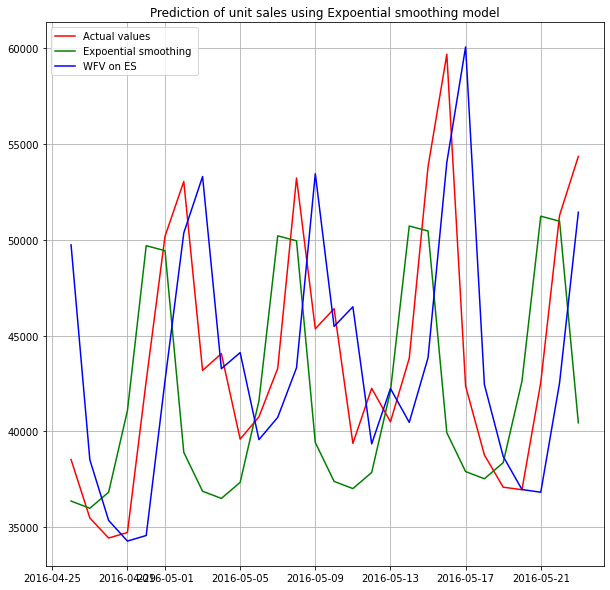

In [70]:
#Prediction using WFV expoential smoothing
x_train = sales_allstate.values 
lst = []
for i in validation.Actual:
  esmodel = ExponentialSmoothing(x_train, trend='additive').fit()
  espredict = esmodel.forecast()
  lst.append(espredict)
  x_train = np.append(x_train, i)

validation['ES_WFV']= lst

print('RMSE using Expoential smoothing : ', math.sqrt(mean_squared_error(validation.Actual, validation.ES_WFV)))
plt.figure(figsize = (10,10))
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.ExponentialSmoothing, color = 'g', label = 'Expoential smoothing ')
plt.plot(validation.ES_WFV, color = 'b', label = 'WFV on ES ')

plt.title('Prediction of unit sales using Expoential smoothing model')
plt.grid()
plt.legend()
plt.show()

#WFV on Expoential smoothing is working fine

#FB PROPHET MODEL

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


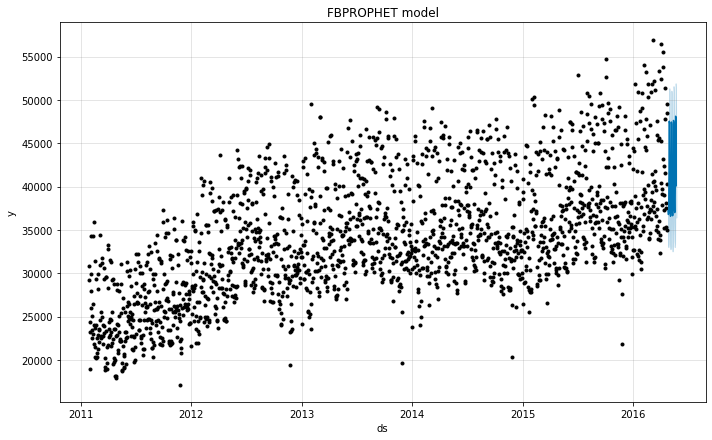

RMSE using FBpropht model:  6911.275888851858


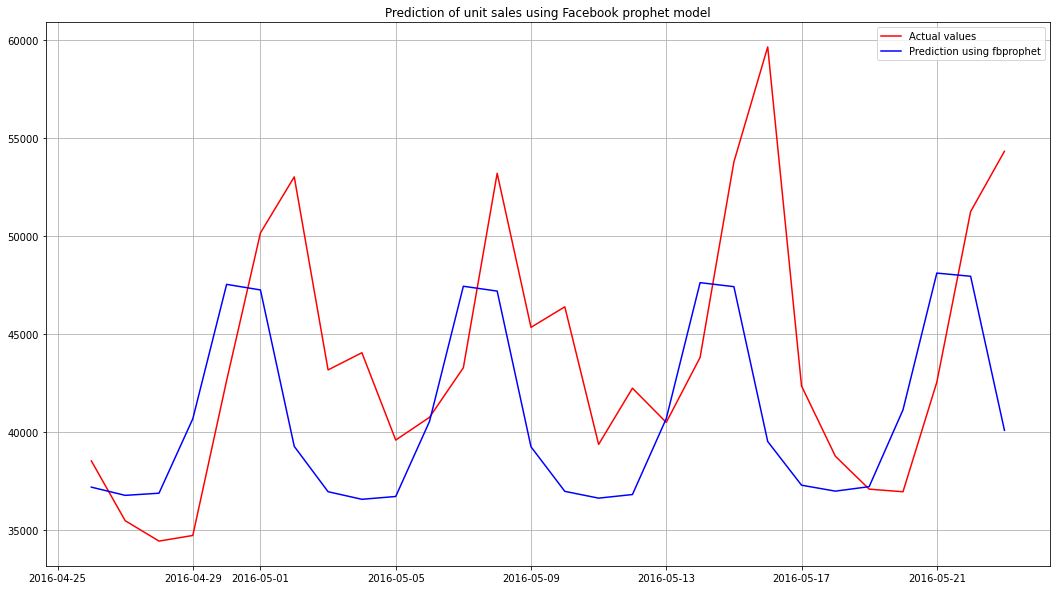

In [71]:
from fbprophet import Prophet

#Structuring the data to feed Prophet model
pdata = pd.DataFrame(sales_allstate, columns=['y'])
pdata['ds']= pdata.index

pdata_val = pd.DataFrame(sales_allstate_val, columns=['y'])
pdata_val['ds']= pdata_val.index

model =  Prophet().fit(pdata)
df = model.predict(pdata_val)

model.plot(df[['ds', 'yhat_lower', 'yhat_upper', 'yhat']])
plt.title('FBPROPHET model')
plt.show()

temp = df.yhat
temp.index= df.ds
validation['fbprophet']= temp

print('RMSE using FBpropht model: ', math.sqrt(mean_squared_error(validation.Actual, df.yhat)))

plt.figure(figsize = (18,10))
plt.plot(validation.Actual, color= 'r', label='Actual values')
plt.plot(validation.fbprophet, color = 'b', label = 'Prediction using fbprophet')
plt.title('Prediction of unit sales using Facebook prophet model')
plt.grid()
plt.legend()
plt.show()

In [72]:
validation

Actual       Average  ...                ES_WFV     fbprophet
date                               ...                                    
2016-04-26  38537.0  33988.624673  ...   [49727.04563841873]  37198.210990
2016-04-27  35487.0  33988.624673  ...   [38522.02375790733]  36779.050216
2016-04-28  34445.0  33988.624673  ...   [35364.05951522897]  36888.651815
2016-04-29  34732.0  33988.624673  ...   [34285.54391731883]  40687.873673
2016-04-30  42640.0  33988.624673  ...  [34576.261975335176]  47546.327607
2016-05-01  50173.0  33988.624673  ...  [42636.254190336425]  47261.945668
2016-05-02  53032.0  33988.624673  ...   [50349.54550308315]  39278.024966
2016-05-03  43181.0  33988.624673  ...   [53289.15716154228]  36964.598092
2016-05-04  44058.0  33988.624673  ...   [43270.60320406479]  36577.866875
2016-05-05  39601.0  33988.624673  ...   [44111.65151690185]  36721.319311
2016-05-06  40763.0  33988.624673  ...   [39574.81657351317]  40555.652808
2016-05-07  43293.0  33988.624673  ...   [40736.33028681545]  47450.352244
2016-05-08  53215.0  33988.624673  ...   [43319.75373473424]  47203.252668
2016-05-09  45353.0  33988.624673  ...   [53438.31183253978]  39257.578917
2016-05-10  46400.0  33988.624673  ...  [45475.627460004755]  36983.309495
2016-05-11  39379.0  33988.624673  ...  [46499.368369663716]  36636.602752
2016-05-12  42248.0  33988.624673  ...   [39352.41094137248]  36820.905551
2016-05-13  40503.0  33988.624673  ...  [42237.956524804475]  40696.867916
2016-05-14  43817.0  33988.624673  ...   [40475.22111800997]  47633.912575
2016-05-15  53796.0  33988.624673  ...   [43842.60993234842]  47429.789566
2016-05-16  59665.0  33988.624673  ...  [54023.173424080276]  39527.608580
2016-05-17  42362.0  33988.624673  ...   [60046.72051191573]  37297.196715
2016-05-18  38777.0  33988.624673  ...  [42443.488594383256]  36994.519962
2016-05-19  37096.0  33988.624673  ...  [38701.970878351436]  37222.788890
2016-05-20  36963.0  33988.624673  ...   [36972.81230598937]  41142.372195
2016-05-21  42552.0  33988.624673  ...   [36831.60021721716]  48122.367144
2016-05-22  51262.0  33988.624673  ...  [42526.790556653046]  47960.157155
2016-05-23  54338.0  33988.624673  ...   [51427.62307332999]  40098.449145

[28 rows x 10 columns]

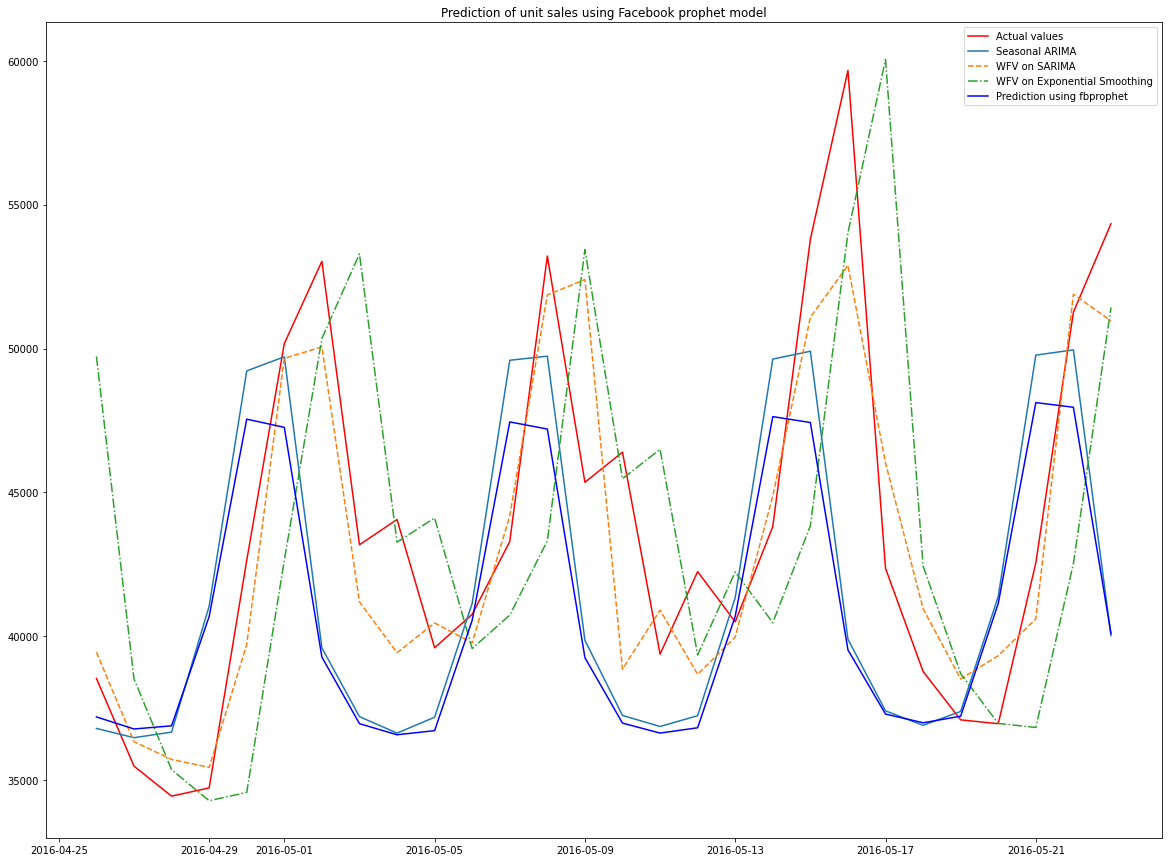

In [73]:
plt.figure(figsize = (20, 15))
plt.plot(validation.Actual, color= 'r', label='Actual values')

#plt.plot(validation.Average, label= 'Average naive method')
#plt.plot(validation.WFV_avg, label= 'WFV ON Average naive method')

#plt.plot(validation.Naive, lable='Naive method')

plt.plot(validation.ARIMA, label = 'Seasonal ARIMA')
plt.plot(validation.WFV_ARIMA,'--', label = 'WFV on SARIMA')

#plt.plot(validation.ExponentialSmoothing, label = 'Exponential Smoothing')
plt.plot(validation.ES_WFV,'-.', label = 'WFV on Exponential Smoothing')

plt.plot(validation.fbprophet, color = 'b', label = 'Prediction using fbprophet')

plt.title('Prediction of unit sales using Facebook prophet model')

plt.legend()
plt.show()

In [74]:
col = validation.columns
print('RMSE FOR DIFFERENT NAIVE AND STATISTICAL METHODS')
for i in col[1:]:
  print('{0:<20} : {1}'.format(i, round(math.sqrt(mean_squared_error(validation.Actual, validation[i]))),3))

RMSE FOR DIFFERENT NAIVE AND STATISTICAL METHODS
Average              : 11819
WFV_avg              : 6601
Naive                : 6500
ARIMA                : 6849
WFV_ARIMA            : 3097
AutoARIMA            : 11614
ExponentialSmoothing : 7010
ES_WFV               : 6574
fbprophet            : 6911


Seasonal ARIMA AND Expoential smoothing techinques are working fine with walk forward validation.

# *ML Models*

Above Naive and statistical method are not predsicting good 

Predictiong with ML algorithms

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [76]:
#Structuring the dataset in the form of samples

train_sequence = pd.DataFrame(sales_allstate)
lst =['t-1', 't-2','t-3', 't-4','t-5', 't-6']

train_sequence.columns=['Actual']
for i in range(len(lst)):
  
  train_sequence[lst[i]] = train_sequence.Actual.shift((i+1))
  train_sequence.head(5)
train_sequence=train_sequence.dropna()


test_sequence = pd.DataFrame(sales_allstate_val)
test_sequence.columns=['Actual']
for i in range(len(lst)):
  
  test_sequence[lst[i]] = test_sequence.Actual.shift((i+1))
  test_sequence.head(5)
test_sequence=test_sequence.dropna()

X_train = np.array(train_sequence[lst])
y_tarin = np.array(train_sequence.Actual)

X_test = np.array(test_sequence[lst])
y_test = np.array(test_sequence.Actual)

In [77]:
X_train[0]

array([27931., 18890., 24388., 23271., 29189., 30839.])

In [78]:
model= Sequential()
model.add(Dense(100, input_dim=len(lst), activation ='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_tarin, epochs=1000,  validation_split=0.2, callbacks=EarlyStopping(monitor='val_loss', patience=10, verbose=1))

Epoch 1/1000
48/48 [==============================] - 1s 10ms/step - loss: 1091000323.9184 - val_loss: 46202980.0000
Epoch 2/1000
48/48 [==============================] - 0s 3ms/step - loss: 26711737.3061 - val_loss: 27000210.0000
Epoch 3/1000
48/48 [==============================] - 0s 3ms/step - loss: 19562088.2857 - val_loss: 25199180.0000
Epoch 4/1000
48/48 [==============================] - 0s 3ms/step - loss: 18506333.2449 - val_loss: 23937570.0000
Epoch 5/1000
48/48 [==============================] - 0s 3ms/step - loss: 16684480.6531 - val_loss: 22866250.0000
Epoch 6/1000
48/48 [==============================] - 0s 3ms/step - loss: 17104779.6531 - val_loss: 21962050.0000
Epoch 7/1000
48/48 [==============================] - 0s 3ms/step - loss: 15754087.7551 - val_loss: 21478548.0000
Epoch 8/1000
48/48 [==============================] - 0s 3ms/step - loss: 14781243.8367 - val_loss: 20589318.0000
Epoch 9/1000
48/48 [==============================] - 0s 3ms/step - loss: 15183361.22

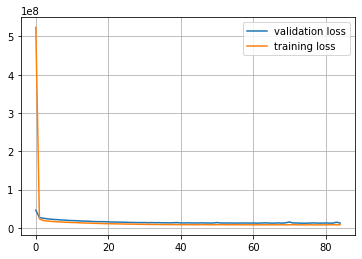

RMSE using MLP:  4020.5918143396793


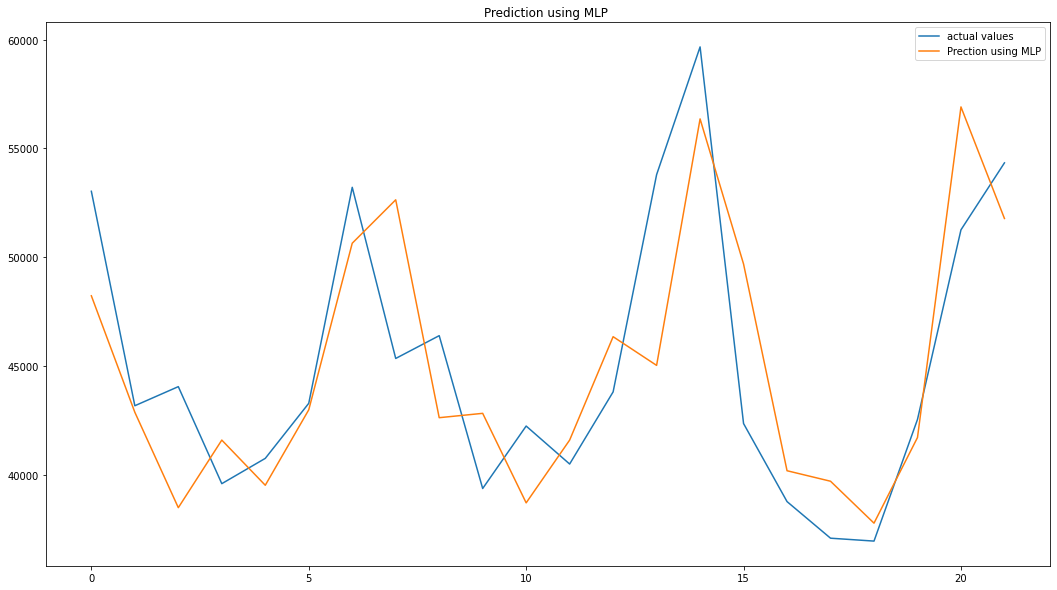

In [79]:

#plt.figure(figsize=(10,10))
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.grid()
plt.show()


predict_MLP = model.predict(X_test)

print('RMSE using MLP: ', math.sqrt(mean_squared_error(y_test,predict_MLP)))
plt.figure(figsize=(18,10))
plt.plot(y_test, label='actual values')
plt.plot(predict_MLP, label = 'Prection using MLP')
plt.title('Prediction using MLP ')
plt.legend()
plt.show()

# Multistep ahesd prediction using MIMO method

In [80]:
#Multistep ahesd prediction using MIMO method

#Unit sales per state
#Unit sales per store
#Unit sales per department
#Unit sales per categoty

In [81]:
#WE WANT TO PREDICT THE UNIT SALES FOR 3 STATES FOR 28 DAYS

In [82]:
state_train

state_id         CA       TX       WI
date                                 
2011-01-29  13683.0   8670.0   8486.0
2011-01-30  12525.0   8862.0   7802.0
2011-01-31   9852.0   6522.0   6897.0
2011-02-01  10535.0   7381.0   6472.0
2011-02-02   9669.0   5912.0   3309.0
...             ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0
2016-04-21  14488.0   9602.0  10943.0
2016-04-22  16839.0  10615.0  12807.0
2016-04-23  21578.0  12266.0  14606.0
2016-04-24  22931.0  12282.0  14326.0

[1913 rows x 3 columns]

In [83]:
sample_state_train = pd.DataFrame(state_train)
lst = sample_state_train.columns
for i in range(len(lst)):
  for j in range(1,4):
    
    sample_state_train['{}_lag{}'.format(lst[i], j)]= sample_state_train[lst[i]].shift(j)

sample_state_train   

state_id         CA       TX       WI  ...  WI_lag1  WI_lag2  WI_lag3
date                                   ...                           
2011-01-29  13683.0   8670.0   8486.0  ...      NaN      NaN      NaN
2011-01-30  12525.0   8862.0   7802.0  ...   8486.0      NaN      NaN
2011-01-31   9852.0   6522.0   6897.0  ...   7802.0   8486.0      NaN
2011-02-01  10535.0   7381.0   6472.0  ...   6897.0   7802.0   8486.0
2011-02-02   9669.0   5912.0   3309.0  ...   6472.0   6897.0   7802.0
...             ...      ...      ...  ...      ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0  ...  10864.0  11139.0  14899.0
2016-04-21  14488.0   9602.0  10943.0  ...  10595.0  10864.0  11139.0
2016-04-22  16839.0  10615.0  12807.0  ...  10943.0  10595.0  10864.0
2016-04-23  21578.0  12266.0  14606.0  ...  12807.0  10943.0  10595.0
2016-04-24  22931.0  12282.0  14326.0  ...  14606.0  12807.0  10943.0

[1913 rows x 12 columns]

In [84]:
sample_state_train = sample_state_train.dropna()
sample_state_train

state_id         CA       TX       WI  ...  WI_lag1  WI_lag2  WI_lag3
date                                   ...                           
2011-02-01  10535.0   7381.0   6472.0  ...   6897.0   7802.0   8486.0
2011-02-02   9669.0   5912.0   3309.0  ...   6472.0   6897.0   7802.0
2011-02-03  11066.0   8494.0   8371.0  ...   3309.0   6472.0   6897.0
2011-02-04  11227.0   5970.0   8765.0  ...   8371.0   3309.0   6472.0
2011-02-05  14818.0   8672.0  10858.0  ...   8765.0   8371.0   3309.0
...             ...      ...      ...  ...      ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0  ...  10864.0  11139.0  14899.0
2016-04-21  14488.0   9602.0  10943.0  ...  10595.0  10864.0  11139.0
2016-04-22  16839.0  10615.0  12807.0  ...  10943.0  10595.0  10864.0
2016-04-23  21578.0  12266.0  14606.0  ...  12807.0  10943.0  10595.0
2016-04-24  22931.0  12282.0  14326.0  ...  14606.0  12807.0  10943.0

[1910 rows x 12 columns]

In [85]:
sample_state_train.columns

Index(['CA', 'TX', 'WI', 'CA_lag1', 'CA_lag2', 'CA_lag3', 'TX_lag1', 'TX_lag2',
       'TX_lag3', 'WI_lag1', 'WI_lag2', 'WI_lag3'],
      dtype='object', name='state_id')

In [86]:
X_train= np.array(sample_state_train[['CA_lag1', 'CA_lag2', 'CA_lag3', 'TX_lag1','TX_lag2', 'TX_lag3', 'WI_lag1', 'WI_lag2', 'WI_lag3']])

y_train = np.array(sample_state_train[['CA', 'TX', 'WI']])

In [87]:
print(X_train.shape, y_train.shape)
n_input = X_train.shape[1]
n_input

(1910, 9) (1910, 3)


9

In [88]:
model = Sequential()
model.add(Dense(200, input_dim=n_input, activation='relu'))
model.add(Dense(3, activation='linear'))

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train,verbose=1,
          validation_split=0.2, 
          epochs=200,
          shuffle=True)
#callbacks=EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/200
48/48 [==============================] - 1s 5ms/step - loss: 58267916.8980 - val_loss: 8114897.0000
Epoch 2/200
48/48 [==============================] - 0s 3ms/step - loss: 5218667.1633 - val_loss: 6752036.0000
Epoch 3/200
48/48 [==============================] - 0s 3ms/step - loss: 4535867.0204 - val_loss: 5893575.5000
Epoch 4/200
48/48 [==============================] - 0s 3ms/step - loss: 4243280.4082 - val_loss: 5512638.5000
Epoch 5/200
48/48 [==============================] - 0s 3ms/step - loss: 3659207.6684 - val_loss: 5143780.5000
Epoch 6/200
48/48 [==============================] - 0s 3ms/step - loss: 3511342.9388 - val_loss: 4909272.0000
Epoch 7/200
48/48 [==============================] - 0s 3ms/step - loss: 3155160.6454 - val_loss: 4735221.5000
Epoch 8/200
48/48 [==============================] - 0s 3ms/step - loss: 3007081.2219 - val_loss: 4635996.0000
Epoch 9/200
48/48 [==============================] - 0s 3ms/step - loss: 3388603.9949 - val_loss: 4592159.0000


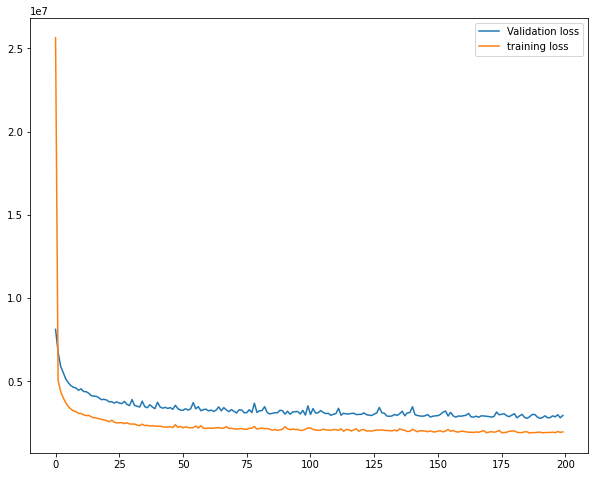

In [89]:
plt.figure(figsize=(10,8))
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.legend()
plt.show()

In [90]:
sales_val

sample_state_test = pd.DataFrame(sales_val)
lst = sample_state_test.columns
for i in range(len(lst)):
  for j in range(1,4):
    sample_state_test['{}_lag{}'.format(lst[i], j)]= sample_state_test[lst[i]].shift(j)

sample_state_test = sample_state_test.dropna()  
sample_state_test

state_id         CA       TX       WI  ...  WI_lag1  WI_lag2  WI_lag3
date                                   ...                           
2016-04-29  14664.0   9655.0  10413.0  ...  10034.0  10542.0  10607.0
2016-04-30  16924.0  12162.0  13554.0  ...  10413.0  10034.0  10542.0
2016-05-01  22071.0  12694.0  15408.0  ...  13554.0  10413.0  10034.0
2016-05-02  23689.0  14193.0  15150.0  ...  15408.0  13554.0  10413.0
2016-05-03  19117.0  10719.0  13345.0  ...  15150.0  15408.0  13554.0
2016-05-04  17830.0  11949.0  14279.0  ...  13345.0  15150.0  15408.0
2016-05-05  17266.0   9909.0  12426.0  ...  14279.0  13345.0  15150.0
2016-05-06  16197.0  10833.0  13733.0  ...  12426.0  14279.0  13345.0
2016-05-07  17382.0  11773.0  14138.0  ...  13733.0  12426.0  14279.0
2016-05-08  22863.0  13412.0  16940.0  ...  14138.0  13733.0  12426.0
2016-05-09  19704.0  11385.0  14264.0  ...  16940.0  14138.0  13733.0
2016-05-10  18916.0  12035.0  15449.0  ...  14264.0  16940.0  14138.0
2016-05-11  16971.0  10580.0  11828.0  ...  15449.0  14264.0  16940.0
2016-05-12  16191.0  11314.0  14743.0  ...  11828.0  15449.0  14264.0
2016-05-13  15498.0  11491.0  13514.0  ...  14743.0  11828.0  15449.0
2016-05-14  18215.0  12320.0  13282.0  ...  13514.0  14743.0  11828.0
2016-05-15  22781.0  12366.0  18649.0  ...  13282.0  13514.0  14743.0
2016-05-16  24448.0  16249.0  18968.0  ...  18649.0  13282.0  13514.0
2016-05-17  17721.0  12228.0  12413.0  ...  18968.0  18649.0  13282.0
2016-05-18  16150.0  11370.0  11257.0  ...  12413.0  18968.0  18649.0
2016-05-19  15678.0  10375.0  11043.0  ...  11257.0  12413.0  18968.0
2016-05-20  16297.0   9162.0  11504.0  ...  11043.0  11257.0  12413.0
2016-05-21  17430.0  12303.0  12819.0  ...  11504.0  11043.0  11257.0
2016-05-22  22847.0  13681.0  14734.0  ...  12819.0  11504.0  11043.0
2016-05-23  24644.0  14815.0  14879.0  ...  14734.0  12819.0  11504.0

[25 rows x 12 columns]

In [91]:
X_test= np.array(sample_state_test[['CA_lag1', 'CA_lag2', 'CA_lag3', 'TX_lag1','TX_lag2', 'TX_lag3', 'WI_lag1', 'WI_lag2', 'WI_lag3']])
y_test = np.array(sample_state_test[['CA', 'TX', 'WI']])

In [92]:
y_test.shape

(25, 3)

In [93]:
predict = model.predict(X_test)

In [94]:
predict

array([[15621.075, 10136.285, 10740.358],
       [16430.498, 10702.64 , 11768.878],
       [20806.424, 13872.124, 14733.757],
       [21497.639, 13916.58 , 14237.362],
       [20080.287, 12440.962, 13062.362],
       [18958.746, 11912.045, 13389.536],
       [17953.229, 11765.38 , 13780.285],
       [18051.586, 11464.102, 13441.75 ],
       [17932.5  , 11987.278, 14636.839],
       [20568.447, 13517.722, 15717.307],
       [23748.678, 15422.14 , 17294.28 ],
       [17007.842, 10631.888, 12164.829],
       [20069.748, 13249.715, 16403.895],
       [16839.861, 10748.7  , 12533.325],
       [18635.713, 13092.28 , 16028.188],
       [17211.568, 11589.026, 13514.431],
       [21469.615, 14496.631, 17030.082],
       [24263.518, 15976.597, 18161.918],
       [21713.287, 13685.263, 14520.165],
       [18287.22 , 12645.94 , 14250.171],
       [16062.   , 11542.851, 13119.63 ],
       [16636.629, 11161.031, 12012.683],
       [17932.21 , 11320.307, 12662.45 ],
       [20441.65 , 13022.18 , 1431

In [95]:
y_test

array([[14664.,  9655., 10413.],
       [16924., 12162., 13554.],
       [22071., 12694., 15408.],
       [23689., 14193., 15150.],
       [19117., 10719., 13345.],
       [17830., 11949., 14279.],
       [17266.,  9909., 12426.],
       [16197., 10833., 13733.],
       [17382., 11773., 14138.],
       [22863., 13412., 16940.],
       [19704., 11385., 14264.],
       [18916., 12035., 15449.],
       [16971., 10580., 11828.],
       [16191., 11314., 14743.],
       [15498., 11491., 13514.],
       [18215., 12320., 13282.],
       [22781., 12366., 18649.],
       [24448., 16249., 18968.],
       [17721., 12228., 12413.],
       [16150., 11370., 11257.],
       [15678., 10375., 11043.],
       [16297.,  9162., 11504.],
       [17430., 12303., 12819.],
       [22847., 13681., 14734.],
       [24644., 14815., 14879.]])

In [96]:

CA=[]; TX=[]; WI=[]
for i in range(y_test.shape[0]):
  CA.append(y_test[i][0])
  TX.append(y_test[i][1])
  WI.append(y_test[i][2])

CA_predict=[]; TX_predict=[]; WI_predict=[]
for i in range(predict.shape[0]):
  CA_predict.append(predict[i][0])
  TX_predict.append(predict[i][1])
  WI_predict.append(predict[i][2])


In [97]:
validation_state = pd.DataFrame(CA, columns =['CA'])
validation_state['TX'] = TX
validation_state['WI'] = WI
validation_state['CA_predict'] = CA_predict
validation_state['TX_predict'] = TX_predict
validation_state['WI_predict'] = WI_predict

index = sales_val.index[3:]
index= [i.date() for i in index]

In [98]:
print('RMSE of CA, TX and WI time series one step prediction using MLP')
print('RMSE of CA time series: ', math.sqrt(mean_squared_error(validation_state.CA, validation_state.CA_predict)))
print('RMSE of TX time series: ', math.sqrt(mean_squared_error(validation_state.TX, validation_state.TX_predict)))
print('RMSE of WI time series: ', math.sqrt(mean_squared_error(validation_state.WI, validation_state.WI_predict)))

RMSE of CA, TX and WI time series one step prediction using MLP
RMSE of CA time series:  1930.2450495226515
RMSE of TX time series:  1478.3718620361171
RMSE of WI time series:  1820.3898009170744


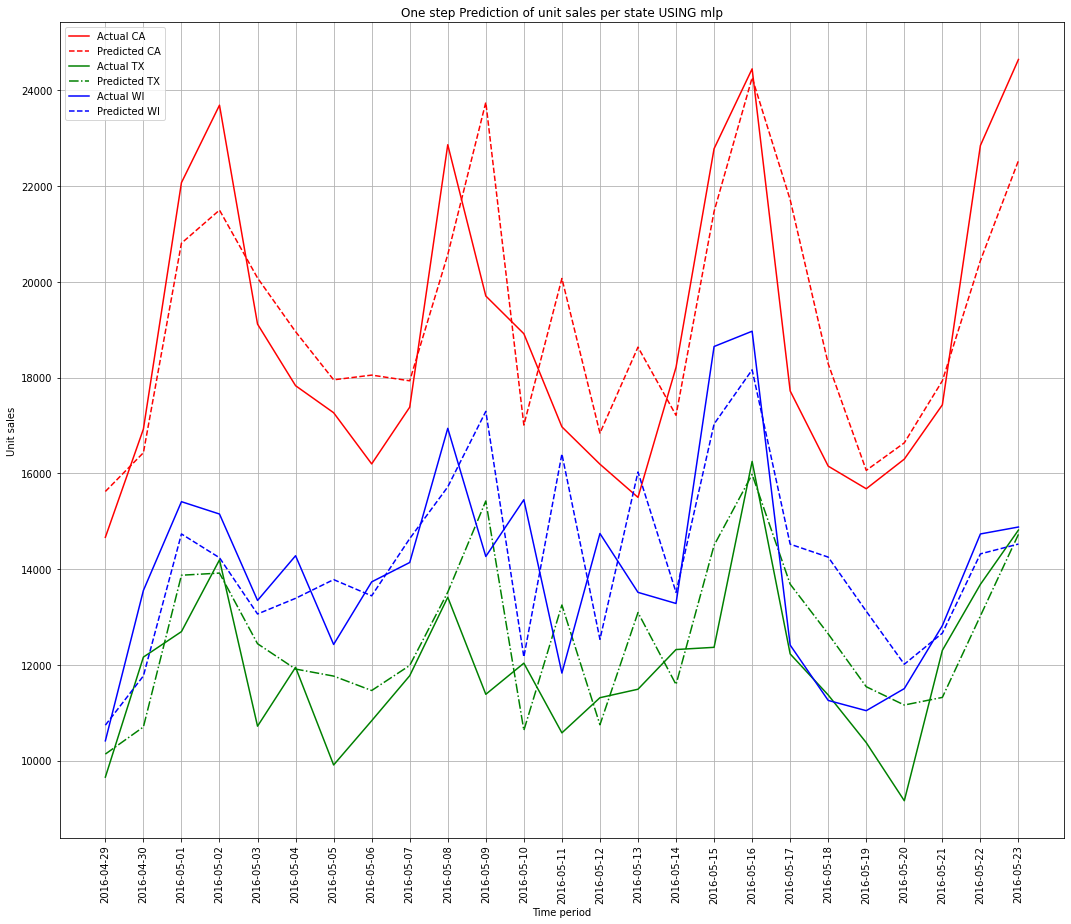

In [99]:
plt.figure(figsize=(18,15))
plt.plot(validation_state.CA, color='r', label = 'Actual CA')
plt.plot(validation_state.CA_predict, '--', color='r', label = 'Predicted CA')
plt.plot(validation_state.TX,  color='g', label = 'Actual TX')
plt.plot(validation_state.TX_predict, '-.', color='g', label = 'Predicted TX')
plt.plot(validation_state.WI, color='b', label = 'Actual WI')
plt.plot(validation_state.WI_predict, '--', color='b', label = 'Predicted WI')
plt.legend()
plt.title('One step Prediction of unit sales per state USING mlp')
plt.xlabel('Time period')
plt.ylabel('Unit sales')
plt.grid()
plt.xticks(range(25), index, rotation='vertical' )
plt.show()

In [100]:
#7 step prediction using MLP
#Structuring the data
sample_state_train = pd.DataFrame(state_train)

lst = sample_state_train.columns

for i in range(len(lst)):
  for j in range(1,5):
    sample_state_train['{}_lag{}'.format(lst[i], j)]= sample_state_train[lst[i]].shift(j)

for i in range(len(lst)):
  for j in range(1,7 ):
    sample_state_train['{}_next{}'.format(lst[i], j)]= sample_state_train[lst[i]].shift(-j)

sample_state_train = sample_state_train.dropna()
sample_state_train.head() 

state_id         CA      TX  ...  WI_lag3_next5  WI_lag3_next6
date                         ...                              
2011-02-05  14818.0  8672.0  ...         6175.0         5914.0
2011-02-06  13416.0  8608.0  ...         5914.0         6568.0
2011-02-07  11566.0  7319.0  ...         6568.0         6187.0
2011-02-08  10421.0  6224.0  ...         6187.0         7889.0
2011-02-09  10094.0  6740.0  ...         7889.0        10142.0

[5 rows x 123 columns]

In [101]:
X_train= np.array(sample_state_train[['CA_lag1', 'CA_lag2', 'CA_lag3', 'CA_lag4', 'TX_lag1', 'TX_lag2', 'TX_lag3', 'TX_lag4', 'WI_lag1', 'WI_lag2', 'WI_lag3','WI_lag4']])
y_train = np.array(sample_state_train[['CA', 'TX', 'WI','CA_next1', 'CA_next2', 'CA_next3', 'CA_next4', 'CA_next5',
       'CA_next6', 'TX_next1', 'TX_next2', 'TX_next3', 'TX_next4', 'TX_next5',
       'TX_next6', 'WI_next1', 'WI_next2', 'WI_next3', 'WI_next4', 'WI_next5',
       'WI_next6']])

In [102]:
print(sales_val.head(4))
sample_state_test = pd.DataFrame(sales_val)
lst = sales_val.columns
for i in range(len(lst)):
  for j in range(1,5):
    sample_state_test['{}_lag{}'.format(lst[i], j)]= sample_state_test[lst[i]].shift(j)


for i in range(len(lst)):
  for j in range(1,7 ):
    sample_state_test['{}_next{}'.format(lst[i], j)]= sample_state_test[lst[i]].shift(-j)

sample_state_test = sample_state_test.dropna()
sample_state_test.head(3)

state_id         CA       TX       WI  ...  WI_lag1  WI_lag2  WI_lag3
date                                   ...                           
2016-04-26  17268.0  10662.0  10607.0  ...      NaN      NaN      NaN
2016-04-27  15012.0   9933.0  10542.0  ...  10607.0      NaN      NaN
2016-04-28  14836.0   9575.0  10034.0  ...  10542.0  10607.0      NaN
2016-04-29  14664.0   9655.0  10413.0  ...  10034.0  10542.0  10607.0

[4 rows x 12 columns]


state_id         CA       TX  ...  WI_lag3_next5  WI_lag3_next6
date                          ...                              
2016-05-03  19117.0  10719.0  ...        12426.0        13733.0
2016-05-04  17830.0  11949.0  ...        13733.0        14138.0
2016-05-05  17266.0   9909.0  ...        14138.0        16940.0

[3 rows x 123 columns]

In [103]:
sample_state_test.columns


X_test= np.array(sample_state_test[['CA_lag1', 'CA_lag2', 'CA_lag3', 'CA_lag4', 'TX_lag1', 'TX_lag2', 'TX_lag3', 'TX_lag4', 'WI_lag1', 'WI_lag2', 'WI_lag3','WI_lag4']])
y_test = np.array(sample_state_test[['CA', 'TX', 'WI','CA_next1', 'CA_next2', 'CA_next3', 'CA_next4', 'CA_next5',
       'CA_next6', 'TX_next1', 'TX_next2', 'TX_next3', 'TX_next4', 'TX_next5',
       'TX_next6', 'WI_next1', 'WI_next2', 'WI_next3', 'WI_next4', 'WI_next5',
       'WI_next6']])

In [104]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1900, 12) (1900, 21)
(15, 12) (15, 21)


In [105]:
model_6= Sequential()
model_6.add(Dense(250, input_dim =12, activation='relu'))
model_6.add(Dense(21, activation='linear'))

model_6.compile(optimizer='adam', loss='mse')
history = model_6.fit(X_train, y_train, validation_split=0.25, epochs=200,verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 67675229.4783 - val_loss: 7583335.5000
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 4899748.7174 - val_loss: 5987585.0000
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 4093790.0870 - val_loss: 5354725.5000
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 3615451.5109 - val_loss: 5193494.5000
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 3462576.9837 - val_loss: 4737425.5000
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 3350176.2283 - val_loss: 4499315.5000
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 3144345.2011 - val_loss: 4308626.5000
Epoch 8/200
45/45 [==============================] - 0s 3ms/step - loss: 3085644.2391 - val_loss: 4272643.0000
Epoch 9/200
45/45 [==============================] - 0s 3ms/step - loss: 2925979.1739 - val_loss: 4167997.0000


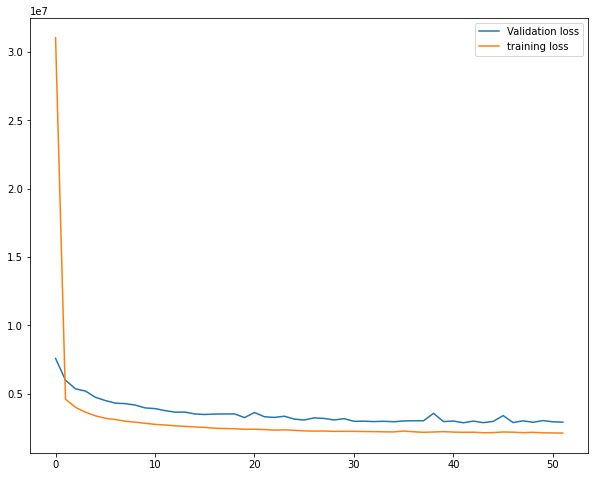

In [106]:
plt.figure(figsize=(10,8))
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.legend()
plt.show()


In [107]:
pred = model_6.predict(X_test)

In [108]:
actaul_ca=[];actaul_ca1=[]; actaul_ca2=[]; actaul_ca3=[];actaul_ca4=[];actaul_ca5=[];actaul_ca6=[]
actaul_tx=[];actaul_tx1=[]; actaul_tx2=[]; actaul_tx3=[]; actaul_tx4=[];actaul_tx5=[];actaul_tx6=[]
actaul_wi=[];actaul_wi1=[]; actaul_wi2=[]; actaul_wi3=[];actaul_wi4=[];actaul_wi5=[];actaul_wi6=[]


for i in range(len(y_test)):
  actaul_ca.append(y_test[i][0])
  actaul_ca1.append(y_test[i][1])
  actaul_ca2.append(y_test[i][2])
  actaul_ca3.append(y_test[i][3])
  actaul_ca4.append(y_test[i][4])
  actaul_ca5.append(y_test[i][5])
  actaul_ca6.append(y_test[i][6])

  actaul_tx.append(y_test[i][7])
  actaul_tx1.append(y_test[i][8])
  actaul_tx2.append(y_test[i][9])
  actaul_tx3.append(y_test[i][10])
  actaul_tx4.append(y_test[i][11])
  actaul_tx5.append(y_test[i][12])
  actaul_tx6.append(y_test[i][13])

  actaul_wi.append(y_test[i][14])
  actaul_wi1.append(y_test[i][15])
  actaul_wi2.append(y_test[i][16])
  actaul_wi3.append(y_test[i][17])
  actaul_wi4.append(y_test[i][18])
  actaul_wi5.append(y_test[i][19])
  actaul_wi6.append(y_test[i][20])

In [109]:
pred[1]

array([15900.825 , 10082.249 , 10605.3125, 15537.346 , 15392.226 ,
       17914.078 , 21613.191 , 22077.434 , 18261.67  ,  9800.154 ,
       10158.009 , 11087.277 , 13653.32  , 14332.118 , 12241.527 ,
       10536.625 , 11784.073 , 13267.701 , 15026.523 , 14083.297 ,
       11714.504 ], dtype=float32)

In [110]:
p_ca=[]; p_ca1=[]; p_ca2=[]; p_ca3=[]; p_ca4=[]; p_ca5=[]; p_ca6=[]
p_tx=[]; p_tx1=[]; p_tx2=[]; p_tx3=[]; p_tx4=[]; p_tx5=[]; p_tx6=[]
p_wi=[]; p_wi1=[]; p_wi2=[]; p_wi3=[]; p_wi4=[]; p_wi5=[]; p_wi6=[]

all= [p_ca,p_ca1,p_ca2,p_ca3,p_ca4,p_ca5,p_ca6,p_tx,p_tx1, p_tx2,p_tx3,p_tx4,p_tx5,p_tx6,p_wi,p_wi1,p_wi2,p_wi3,p_wi4,p_wi5,p_wi6]
for i in range(len(pred)):
  all[0].append(pred[i][0])
  all[1].append(pred[i][1])
  all[2].append(pred[i][2])
  all[3].append(pred[i][3])
  all[4].append(pred[i][4])
  all[5].append(pred[i][5])
  all[6].append(pred[i][6])

  all[7].append(pred[i][7])
  all[8].append(pred[i][8])
  all[9].append(pred[i][9])
  all[10].append(pred[i][10])
  all[11].append(pred[i][11])
  all[12].append(pred[i][12])
  all[13].append(pred[i][13])

  all[14].append(pred[i][14])
  all[15].append(pred[i][15])
  all[16].append(pred[i][16])
  all[17].append(pred[i][17])
  all[18].append(pred[i][18])
  all[19].append(pred[i][19])
  all[20].append(pred[i][20])
  

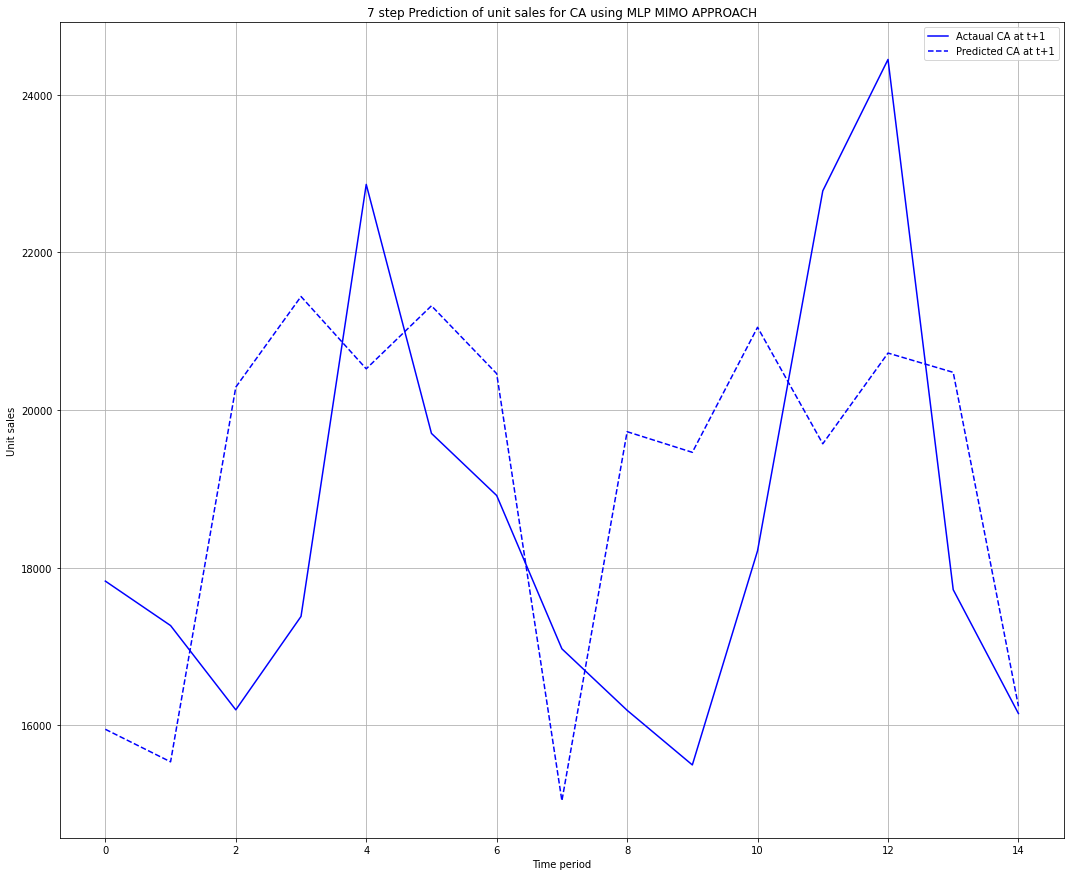

In [111]:
plt.figure(figsize=(18,15))


plt.plot(actaul_ca3, color='b', label = 'Actaual CA at t+1')
plt.plot(p_ca3, '--', color='b', label = 'Predicted CA at t+1')
"""
plt.plot(actaul_ca4, color='g', label = 'Actaual CA at t+2')
plt.plot(p_ca4, '--', color='g', label = 'Predicted CA at t+2')
plt.plot(actaul_ca, color='r', label = 'Actaual CA at t')
plt.plot(p_ca, '--', color='r', label = 'Predicted CA at t')
plt.plot(actaul_ca5, color='r', label = 'Actaual CA at t+3')
plt.plot(p_ca5, '--', color='r', label = 'Predicted CA at t+3')

plt.plot(actaul_ca6, color='b', label = 'Actaual CA at t+4')
plt.plot(p_ca6, '--', color='b', label = 'Predicted CA at t+4')

plt.plot(actaul_tx, color='g', label = 'Actaual CA at t+5')
plt.plot(p_tx, '--', color='g', label = 'Predicted CA at t+5')

plt.plot(actaul_tx1, color='b', label = 'Actaual CA at t+6')
plt.plot(p_tx1, '--', color='b', label = 'Predicted CA at t+6')
"""

plt.legend()
plt.title('7 step Prediction of unit sales for CA using MLP MIMO APPROACH')
plt.xlabel('Time period')
plt.ylabel('Unit sales')
plt.grid()
plt.show()

In [112]:
print('RMSE of CA, TX and WI time series one step prediction using MLP')
print('RMSE of CA time series at t: ', math.sqrt(mean_squared_error(actaul_ca, p_ca)))
print('RMSE of CA time series at t+1: ', math.sqrt(mean_squared_error(actaul_ca3, p_ca3)))
print('RMSE of CA time series at t+2: ', math.sqrt(mean_squared_error(actaul_ca4, p_ca4)))
print('RMSE of CA time series at t+3: ', math.sqrt(mean_squared_error(actaul_ca5, p_ca5)))
print('RMSE of CA time series at t+4: ', math.sqrt(mean_squared_error(actaul_ca6, p_ca6)))
print('RMSE of CA time series at t+5: ', math.sqrt(mean_squared_error(actaul_tx, p_tx)))
print('RMSE of CA time series at t+6: ', math.sqrt(mean_squared_error(actaul_tx1, p_tx1)))

RMSE of CA, TX and WI time series one step prediction using MLP
RMSE of CA time series at t:  2494.748888810002
RMSE of CA time series at t+1:  2851.899403407656
RMSE of CA time series at t+2:  2131.631386536194
RMSE of CA time series at t+3:  1572.3452945267543
RMSE of CA time series at t+4:  1499.9365831826155
RMSE of CA time series at t+5:  1839.7959106260323
RMSE of CA time series at t+6:  1958.1237540885988
